In [51]:
# Data Manuiplation dependencies
# https://numpy.org/
import numpy as np
# https://pandas.pydata.org/
import pandas as pd 
#----------------------------------
# Visualisations dependencies
# https://matplotlib.org/
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#https://seaborn.pydata.org/
import seaborn as sns
#-------------------------------------
import warnings
import itertools
import os
#--------------------------------
sns.set(style="darkgrid")
# Modelling dependencies
#sklearn Dependencies
# All dependencies can be found here https://scikit-learn.org/stable/
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score,confusion_matrix, classification_report

# Ignore warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 90) # display all column of dataframe
pd.set_option('display.max_row', 100)
#-----------------------------------------------------------------------

# Table of Contents

   * EDA
        
     * For Classes 0 and 1
        * Splitting and standardizing data for analysis

        * Random Forest Model with Test Data
            * Random Forest Feature selection

        * Random Forest Model with Validation Data
        
        * Logisitc feature importance
        
        * PCA feature selection
    

# EDA 

In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)        


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [53]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [54]:
# import data and clean it
df = pd.read_csv('Covariate_Features.csv')
df.drop(['long','lat','Coordinates','Transformed_Long','Transformed_Lat','new_long','new_lat','Raster Value'],axis=1,inplace=True)
#df.set_index(['long','lat'],inplace=True)
#del df['Band_28'] # Band 28 did not have any values within it
print('there are ', df.shape[0],'values in the original dataframe')
df.head()

there are  47560 values in the original dataframe


Label     Band_1    Band_2    Band_3    Band_4    Band_5     Band_6  \
0      0  31.780069  0.739527  0.724089  2.688592  4.286776  11.415614   
1      0  31.813374  0.994895  0.985522  2.950744  4.480880  11.294726   
2      0  31.773357  0.926415  0.917783  2.884460  4.443317  11.304877   
3      0  31.735663  0.866177  0.854744  2.819666  4.407386  11.315222   
4      0  31.698177  0.811470  0.797522  2.756468  4.373125  11.326365   

     Band_7    Band_8  Band_9  Band_10    Band_11  Band_12   Band_13  Band_14  \
0  1.205231  2.369100     0.0    0.583  18.129000   12.066  2.265071      0.0   
1  1.439247  2.656430     0.0    0.825  18.056999   12.357  1.786768      0.0   
2  1.349879  2.575939     0.0    0.743  18.049999   12.268  2.265071      0.0   
3  1.260993  2.496295     0.0    0.651  18.042999   12.179  2.265071      0.0   
4  1.172700  2.417583     0.0    0.560  18.035999   12.089  2.265071      0.0   

    Band_15     Band_16    Band_17  Band_18    Band_19  Band_20    Band_21  \
0  0.286720  103.370560  20.921000    0.464  81.175003   -0.371  29.035999   
1  0.289738  103.442802  21.132000    0.414  80.906998   -0.293  29.257999   
2  0.288260  103.370560  21.089001    0.382  80.999001   -0.278  29.172001   
3  0.286658  103.370560  21.046000    0.371  81.091003   -0.278  29.087000   
4  0.284906  103.370560  21.003000    0.371  81.182999   -0.278  29.000999   

   Band_22    Band_23   Band_24  Band_25    Band_26  Band_27  Band_28  \
0    0.586  56.499001  0.646436   12.738  93.734001   10.195      0.0   
1    0.464  56.410999  0.692578   13.023  93.463997   10.131      0.0   
2    0.464  56.409000  0.636535   12.944  93.533997   10.178      0.0   
3    0.473  56.408001  0.592647   12.864  93.603996   10.226      0.0   
4    0.499  56.407001  0.559894   12.785  93.674004   10.274      0.0   

    Band_29  Band_30  Band_31  Band_32    Band_33   Band_34    Band_35  \
0  0.263034      3.0    126.0     20.0  34.562562  0.852259  14.920146   
1  0.263034      3.0    126.0     80.0  34.557776  0.839812  14.818560   
2  0.263034      3.0     50.0     80.0  34.558058  0.388908  14.822458   
3  0.263034      3.0     50.0     80.0  34.558058  0.560225  14.828402   
4  0.263034      3.0     50.0     20.0  34.558058  0.730593  14.847874   

   Band_36   Band_37    Band_38   Band_39   Band_40   Band_41   Band_42  \
0      4.0  0.000000   0.000000  0.869017  0.272429  0.690633  0.734774   
1      1.0  0.000000   0.000000  0.868700  0.271277  0.686508  0.734642   
2      1.0  0.000000   0.000000  0.868858  0.271756  0.688595  0.734720   
3      4.0  4.902162  13.694674  0.868858  0.271756  0.688595  0.734720   
4      6.0  0.000000   0.000000  0.869017  0.272429  0.690633  0.734774   

    Band_43   Band_44   Band_45   Band_46   Band_47   Band_48    Band_49  \
0  0.995996  0.517588  0.766863  0.585417  0.136775  0.233711   9.869781   
1  0.993765  0.515353  0.763166  0.585874  0.140325  0.231277  10.191885   
2  0.995055  0.516355  0.765130  0.585677  0.138392  0.231277  10.895460   
3  0.995055  0.516355  0.765130  0.585677  0.138392  0.232287  11.379321   
4  0.995996  0.517588  0.766863  0.585417  0.136775  0.232287  11.595043   

    Band_50   Band_51   Band_52   Band_53    Band_54    Band_55  Band_56  \
0  0.231839  0.568856  0.774400  2.789958  20.956160  19.635271      3.0   
1  0.232168  0.569326  0.772752  3.045210  20.672230  19.538315      3.0   
2  0.231948  0.569111  0.772752  2.977921  20.761681  19.540298      3.0   
3  0.231948  0.569111  0.772752  2.917063  20.851133  19.542603      3.0   
4  0.231839  0.568856  0.774400  2.857528  20.945560  19.545317      3.0   

   Band_57  Band_58     Band_59   Band_60  Band_61  
0      1.0      0.0    0.000000  0.409060     -1.0  
1      1.0      0.0    0.000000  0.405172     -1.0  
2      1.0      0.0    0.000000  0.407236     -1.0  
3      1.0      2.0  235.674698  0.407236      0.0  
4      1.0      0.0    0.000000  0.409060     -1.0

In [55]:
# change names of Bands to covariate names 
#cov_names = pd.read_csv('Covariate_names.csv')
#cov_names.to_dict()
#cov_names.set_index('Band_names')['Covariate_names'].to_dict()

In [56]:
df.rename(columns= {'Band_1': ' fs_dist_fs_2020',
 'Band_2': ' fs_dist_hf_2019',
 'Band_3': ' fs_dist_hf1_2020',
 'Band_4': ' fs_dist_market_2020',
 'Band_5': ' fs_dist_mosques_2017',
 'Band_6': ' fs_dist_school_2020',
 'Band_7': ' fs_dist_school1_2018',
 'Band_8': ' fs_dist_well_2018',
 'Band_9': ' fs_electric_dist_2020',
 'Band_10': ' in_dist_rd_2016',
 'Band_11': ' in_dist_rd_intersect_2016',
 'Band_12': ' in_dist_waterway_2016',
 'Band_13': ' in_night_light_2016',
 'Band_14': ' ph_base_water_2010',
 'Band_15': ' ph_bio_dvst_2015',
 'Band_16': ' ph_climate_risk_2020',
 'Band_17': ' ph_dist_aq_veg_2015',
 'Band_18': ' ph_dist_art_surface_2015',
 'Band_19': ' ph_dist_bare_2015',
 'Band_20': ' ph_dist_cultivated_2015',
 'Band_21': ' ph_dist_herb_2015',
 'Band_22': ' ph_dist_inland_water_2018',
 'Band_23': ' ph_dist_open_coast_2020',
 'Band_24': ' ph_dist_riv_network_2007',
 'Band_25': ' ph_dist_shrub_2015',
 'Band_26': ' ph_dist_sparse_veg_2015',
 'Band_27': ' ph_dist_woody_tree_2015',
 'Band_28': ' ph_gdmhz_2005',
 'Band_29': ' ph_grd_water_2000',
 'Band_30': ' ph_hzd_index_2011',
 'Band_31': ' ph_land_c1_2019',
 'Band_32': ' ph_land_c2_2020',
 'Band_33': ' ph_max_tem_2019',
 'Band_34': ' ph_ndvi_2019',
 'Band_35': ' ph_pm25_2016',
 'Band_36': ' ph_slope_2000',
 'Band_37': ' po_pop_fb_2018',
 'Band_38': ' po_pop_un_2020',
 'Band_39': ' ses_an_visits_2016',
 'Band_40': ' ses_child_stunted_2018',
 'Band_41': ' ses_dpt3_2018',
 'Band_42': ' ses_hf_delivery_2018',
 'Band_43': ' ses_impr_water_src_2016',
 'Band_44': ' ses_ITN_2016',
 'Band_45': ' ses_m_lit_2018',
 'Band_46': ' ses_measles_2018',
 'Band_47': ' ses_odef_2018',
 'Band_48': ' ses_pfpr_2017',
 'Band_49': ' ses_preg_2017',
 'Band_50': ' ses_unmet_need_2018',
 'Band_51': ' ses_w_anemia_2018',
 'Band_52': ' ses_w_lit_2018',
 'Band_53': ' sh_dist_conflict_2020',
 'Band_54': ' sh_dist_mnr_pofw_2019',
 'Band_55': ' sh_dist_pofw_2019',
 'Band_56': ' sh_ethno_den_2020',
 'Band_57': ' sh_pol_relev_ethnic_gr_2019',
 'Band_58': ' uu_bld_count_2020',
 'Band_59': ' uu_bld_den_2020',
 'Band_60': ' uu_impr_housing_2015',
 'Band_61': ' uu_urb_bldg_2018'},inplace=True)
df.reset_index(inplace=True)
del df['index']
df.head()
#df.to_csv('Covariates_w_names.csv',index=False)

Label   fs_dist_fs_2020   fs_dist_hf_2019   fs_dist_hf1_2020  \
0      0         31.780069          0.739527           0.724089   
1      0         31.813374          0.994895           0.985522   
2      0         31.773357          0.926415           0.917783   
3      0         31.735663          0.866177           0.854744   
4      0         31.698177          0.811470           0.797522   

    fs_dist_market_2020   fs_dist_mosques_2017   fs_dist_school_2020  \
0              2.688592               4.286776             11.415614   
1              2.950744               4.480880             11.294726   
2              2.884460               4.443317             11.304877   
3              2.819666               4.407386             11.315222   
4              2.756468               4.373125             11.326365   

    fs_dist_school1_2018   fs_dist_well_2018   fs_electric_dist_2020  \
0               1.205231            2.369100                     0.0   
1               1.439247            2.656430                     0.0   
2               1.349879            2.575939                     0.0   
3               1.260993            2.496295                     0.0   
4               1.172700            2.417583                     0.0   

    in_dist_rd_2016   in_dist_rd_intersect_2016   in_dist_waterway_2016  \
0             0.583                   18.129000                  12.066   
1             0.825                   18.056999                  12.357   
2             0.743                   18.049999                  12.268   
3             0.651                   18.042999                  12.179   
4             0.560                   18.035999                  12.089   

    in_night_light_2016   ph_base_water_2010   ph_bio_dvst_2015  \
0              2.265071                  0.0           0.286720   
1              1.786768                  0.0           0.289738   
2              2.265071                  0.0           0.288260   
3              2.265071                  0.0           0.286658   
4              2.265071                  0.0           0.284906   

    ph_climate_risk_2020   ph_dist_aq_veg_2015   ph_dist_art_surface_2015  \
0             103.370560             20.921000                      0.464   
1             103.442802             21.132000                      0.414   
2             103.370560             21.089001                      0.382   
3             103.370560             21.046000                      0.371   
4             103.370560             21.003000                      0.371   

    ph_dist_bare_2015   ph_dist_cultivated_2015   ph_dist_herb_2015  \
0           81.175003                    -0.371           29.035999   
1           80.906998                    -0.293           29.257999   
2           80.999001                    -0.278           29.172001   
3           81.091003                    -0.278           29.087000   
4           81.182999                    -0.278           29.000999   

    ph_dist_inland_water_2018   ph_dist_open_coast_2020  \
0                       0.586                 56.499001   
1                       0.464                 56.410999   
2                       0.464                 56.409000   
3                       0.473                 56.408001   
4                       0.499                 56.407001   

    ph_dist_riv_network_2007   ph_dist_shrub_2015   ph_dist_sparse_veg_2015  \
0                   0.646436               12.738                 93.734001   
1                   0.692578               13.023                 93.463997   
2                   0.636535               12.944                 93.533997   
3                   0.592647               12.864                 93.603996   
4                   0.559894               12.785                 93.674004   

    ph_dist_woody_tree_2015   ph_gdmhz_2005   ph_grd_water_2000  \
0                    10.195             0.0            0.263034   
1                    10.13

In [57]:
# create pie chart data
pie_data= count_values_in_column(df,"Label") # save data aS a dataframe
count_values_in_column(df,"Label")

Total  Percentage
2  32089       67.47
0  15202       31.96
1    269        0.57

<function matplotlib.pyplot.show(close=None, block=None)>

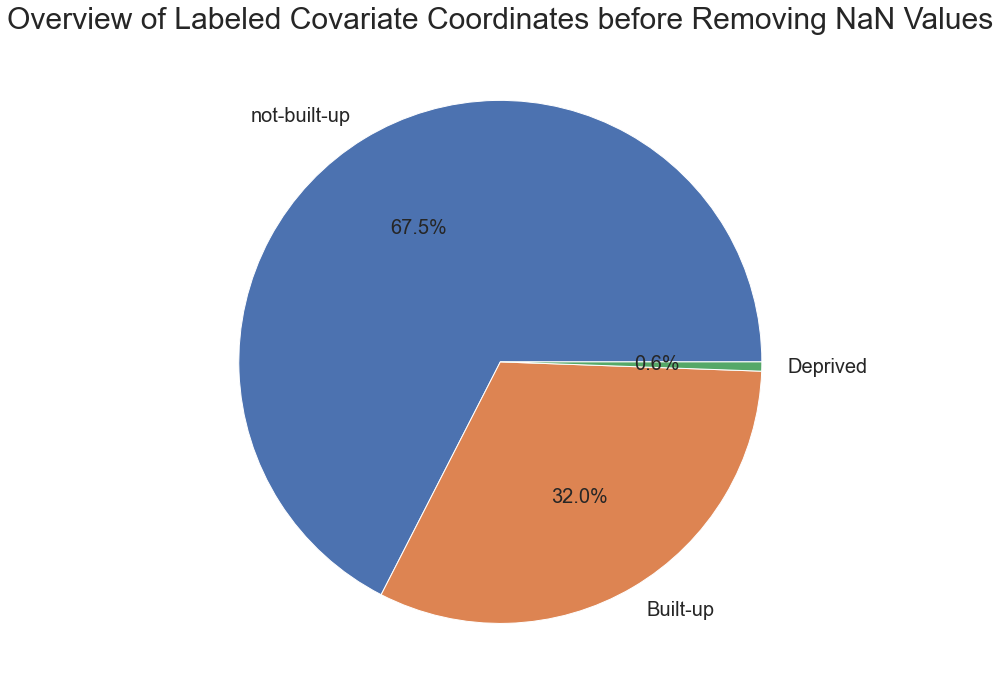

In [58]:
plt.figure(figsize=(10,10))
labels = ['not-built-up','Built-up', 'Deprived']
plt.title('Overview of Labeled Covariate Coordinates before Removing NaN Values', fontsize=30)
plt.pie(pie_data['Total'], labels=labels, autopct='%1.1f%%', textprops={'fontsize': 20})
plt.rcParams["axes.labelweight"] = "bold"
plt.tight_layout()
plt.show

In [59]:
#checking NAN on Covariate data values
null_values = df[df.isnull().any(axis=1)]
print('there are',df[df.isnull().any(axis=1)].shape[0], 'nan values in the dataframe')
print(null_values['Label'].value_counts())
df.dropna(inplace=True)
print('there are ',df.shape[0],'rows of data after removing nan values')

there are 1987 nan values in the dataframe
2    1986
0       1
Name: Label, dtype: int64
there are  45573 rows of data after removing nan values


In [60]:
# create pie chart data
pie_data= count_values_in_column(df,"Label") # save data aS a dataframe
count_values_in_column(df,"Label")

Total  Percentage
2  30103       66.05
0  15201       33.36
1    269        0.59

<function matplotlib.pyplot.show(close=None, block=None)>

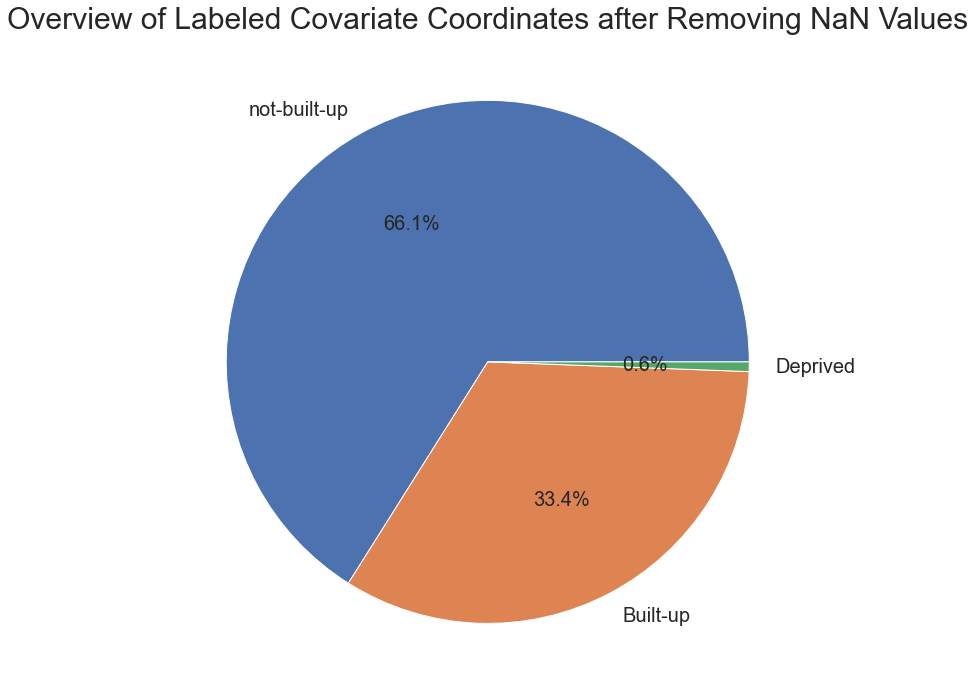

In [61]:
plt.figure(figsize=(10,10))
labels = ['not-built-up','Built-up', 'Deprived']
plt.title('Overview of Labeled Covariate Coordinates after Removing NaN Values', fontsize=30)
plt.pie(pie_data['Total'], labels=labels, autopct='%1.1f%%', textprops={'fontsize': 20})
plt.rcParams["axes.labelweight"] = "bold"
plt.tight_layout()
plt.show

In [62]:
# Some Useful Functions
def Distribution_plot(dataframe,feature, target, title, xlabel):
    """"
    Plot Distribution of feature for both classes
    
    Parameters
    ------------
    dataframe: Training dataframe
    feature: Variable to find distribution
    target: Dependent variable column containing all classes
    title: Plot title
    """
    
    # set the figure size
    plt.figure(figsize=(10,8))

    ax = plt.subplot()
    #distribution plot for all classes
    sns.distplot(dataframe[feature][dataframe[target] == 0], bins=50, label="Deprived Area")
    sns.distplot(dataframe[feature][dataframe[target] ==1], bins=50, label="Developed Area")
    sns.distplot(dataframe[feature][dataframe[target] ==2], bins=50, label="Water Area")

    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)

    # Add legend and show plot
    ax.legend(title="Area classification")
    plt.show()

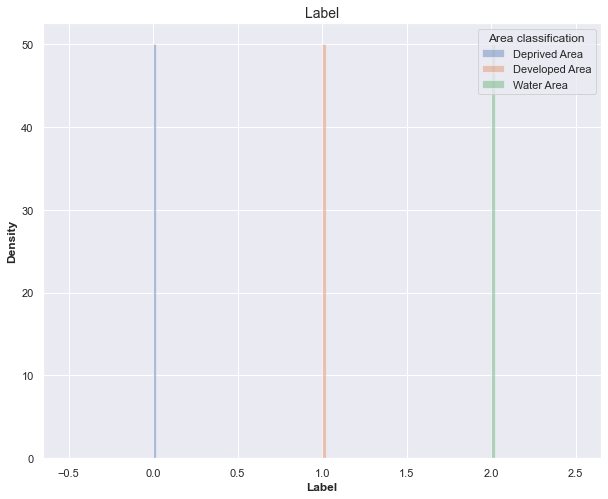

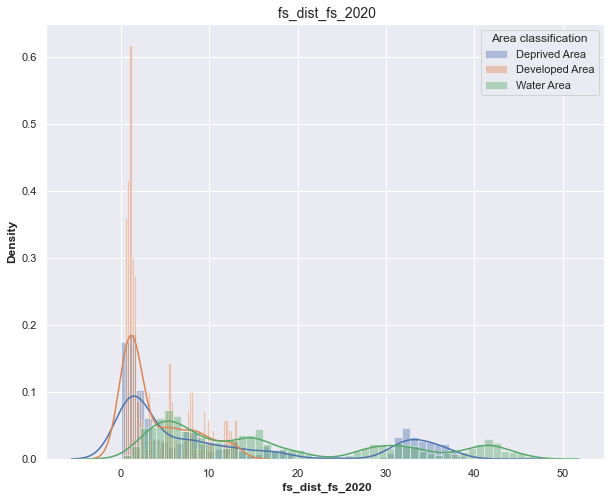

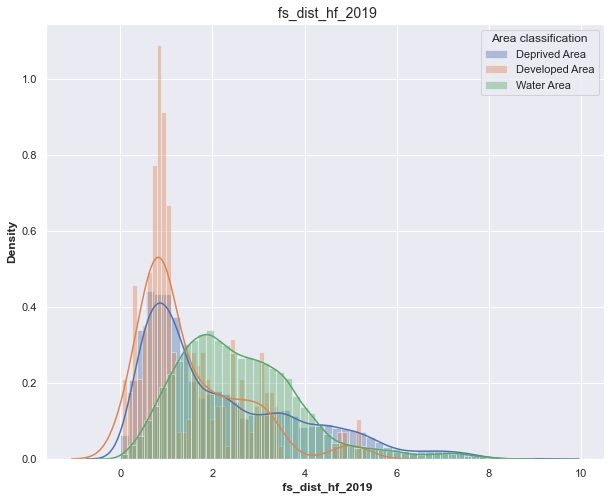

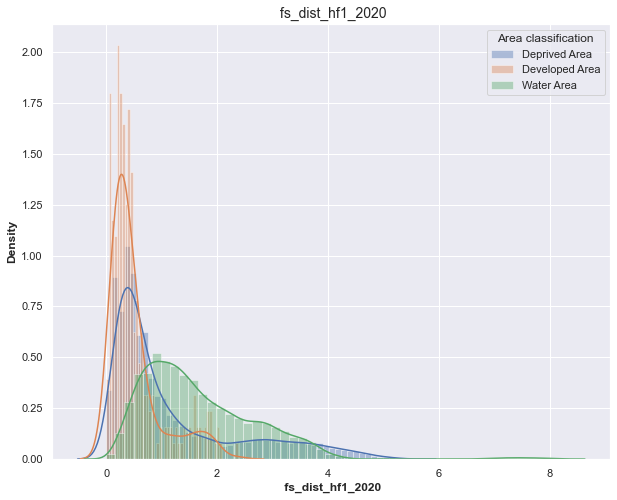

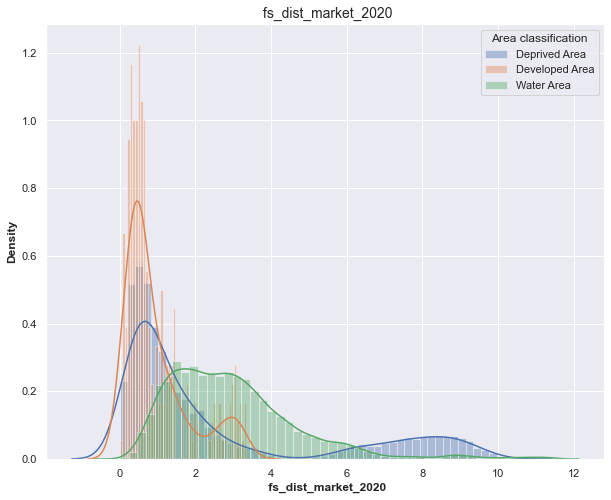

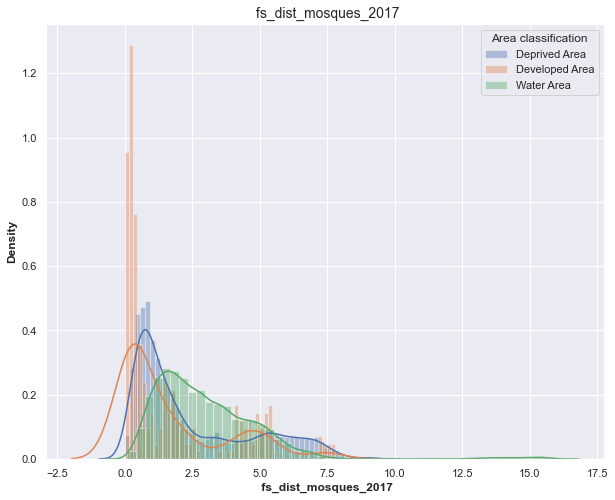

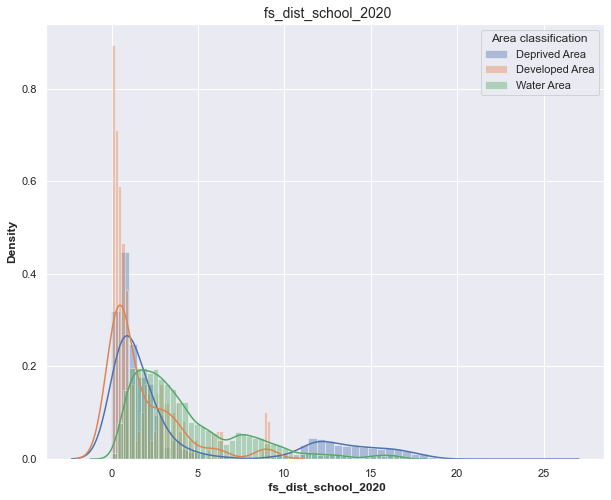

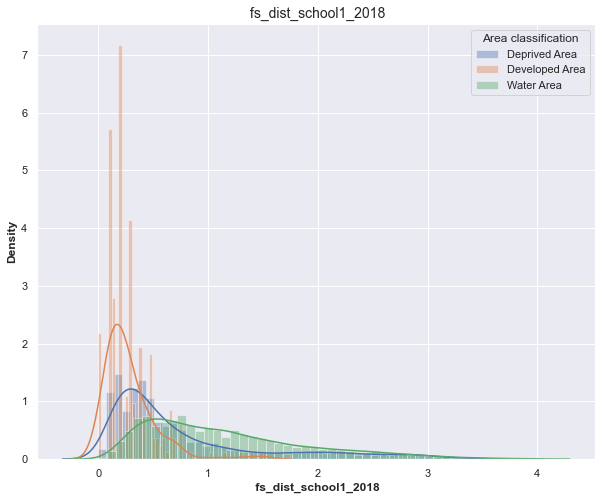

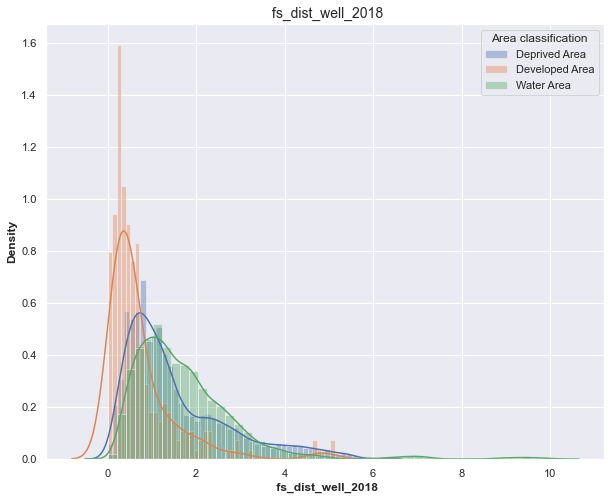

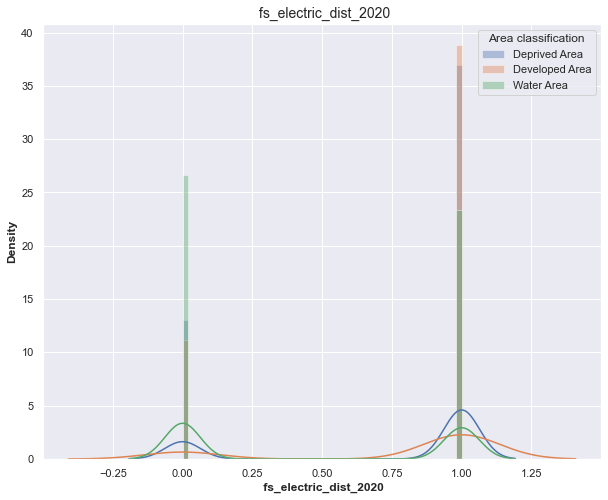

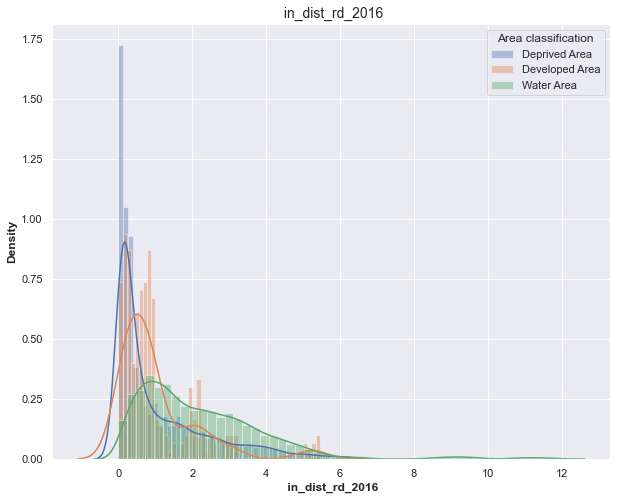

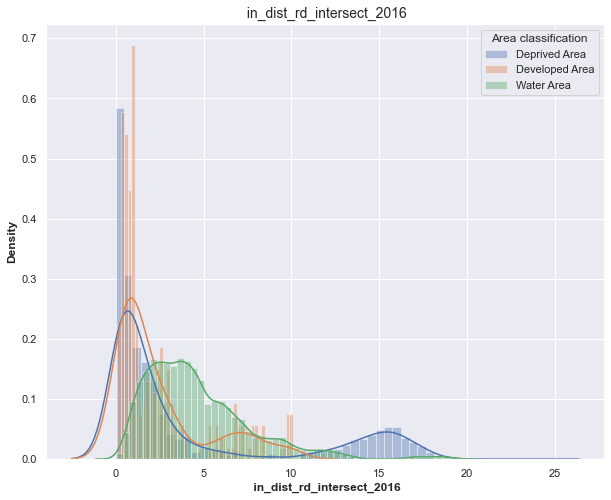

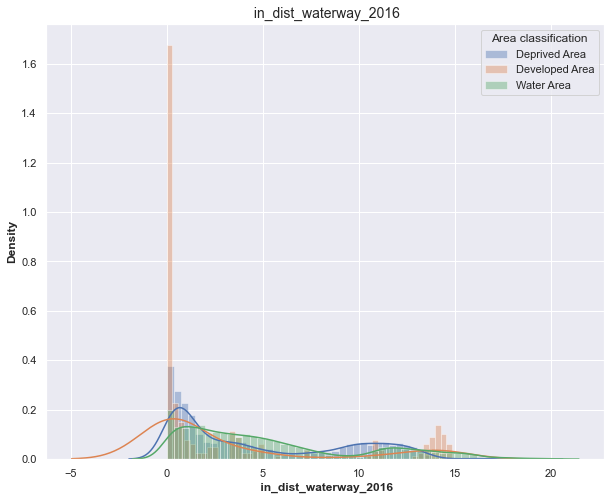

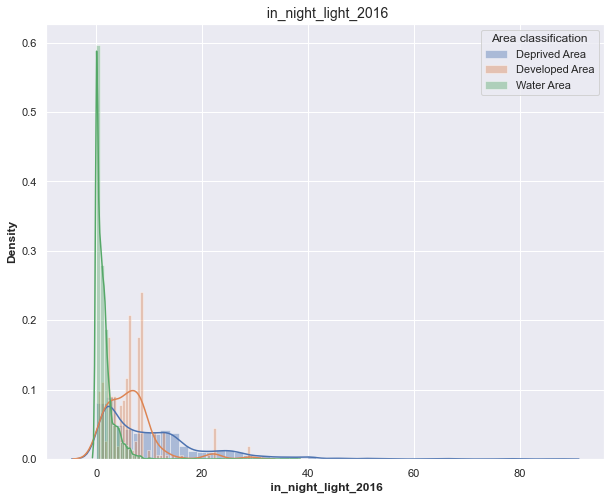

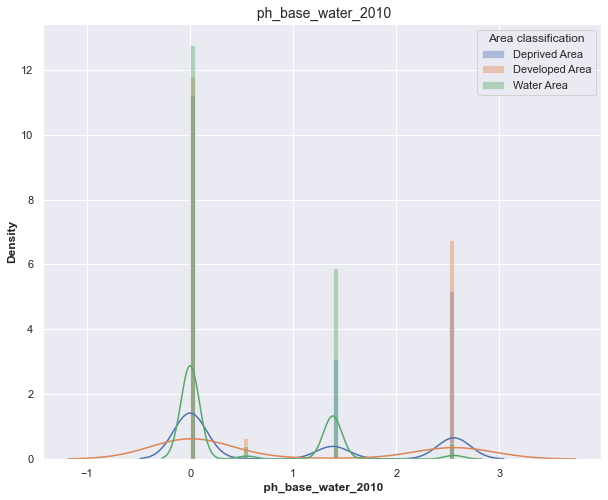

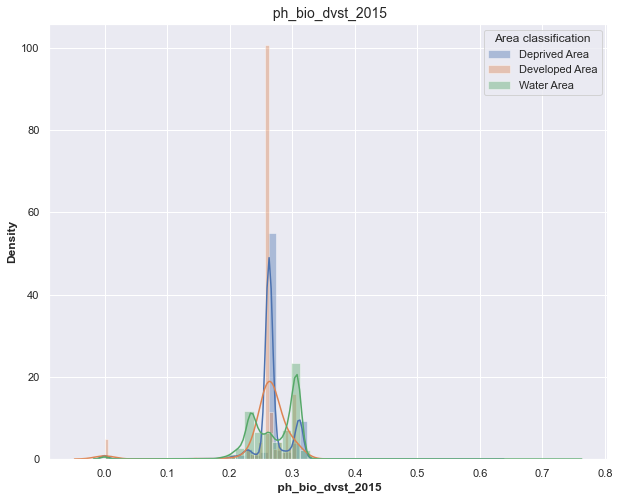

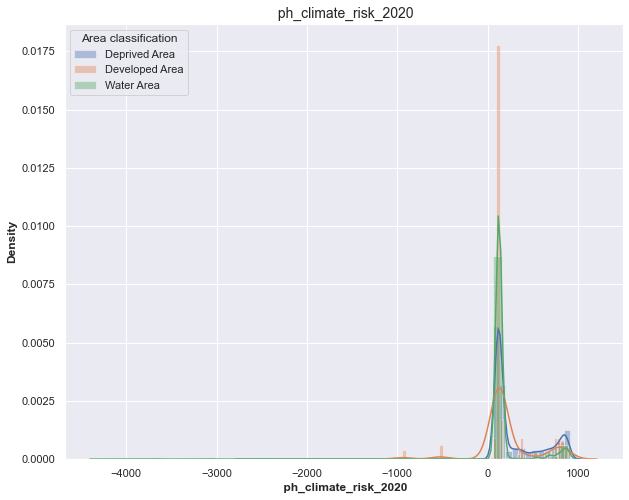

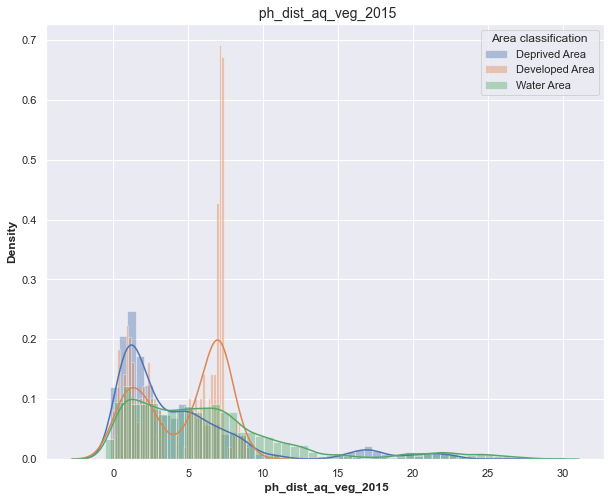

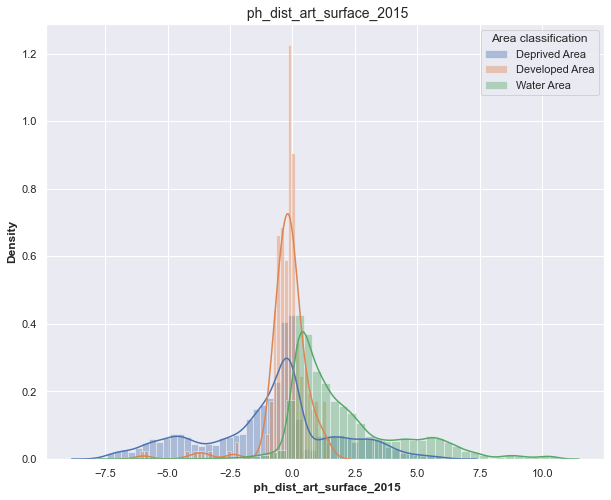

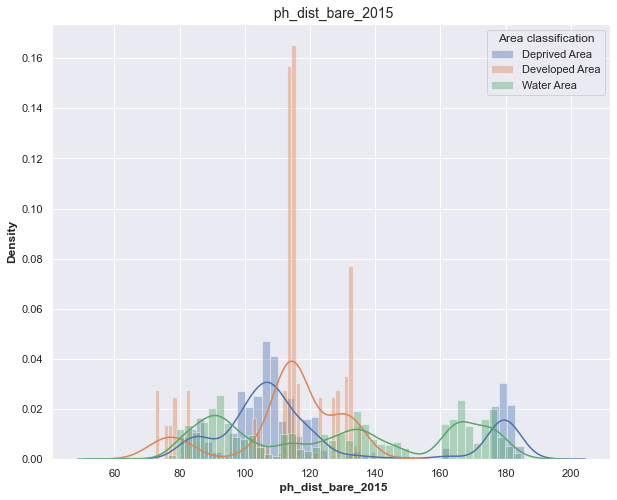

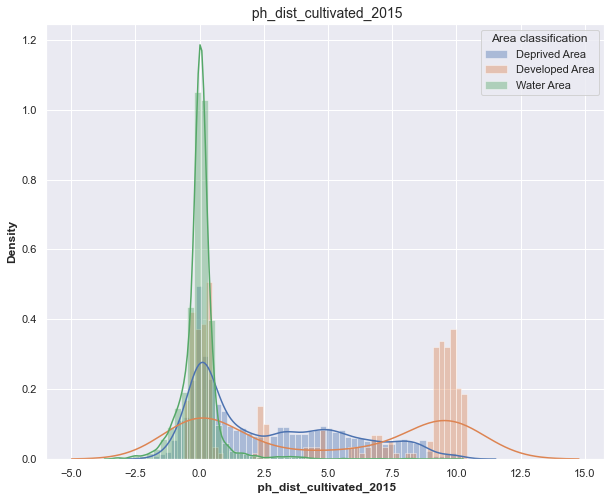

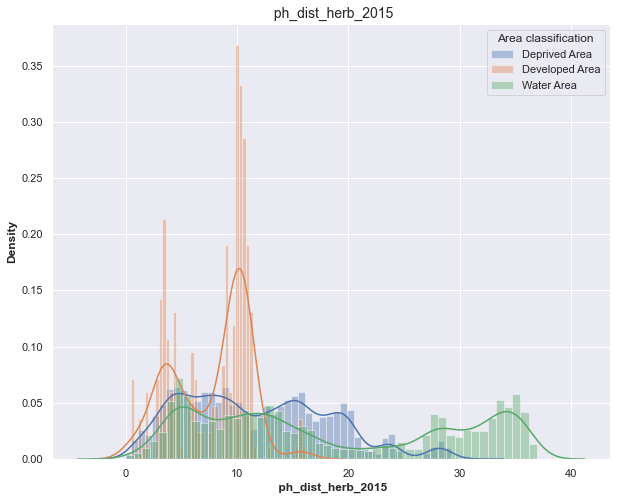

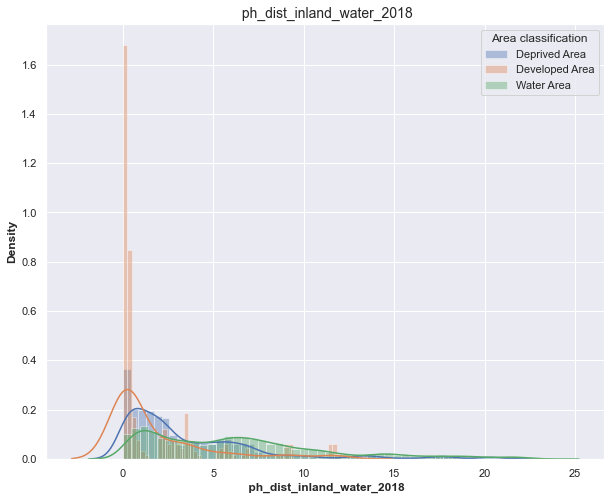

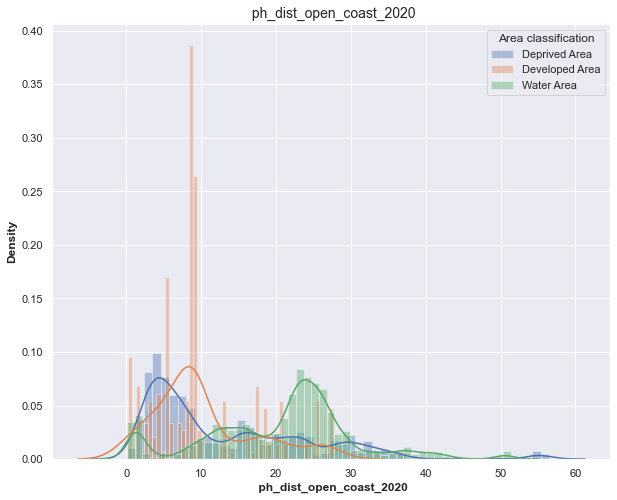

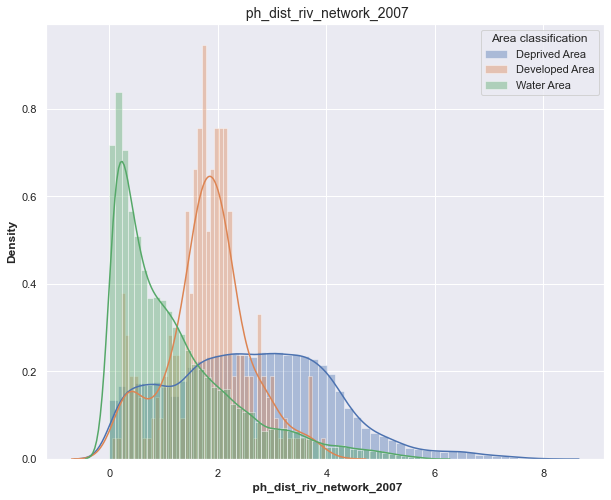

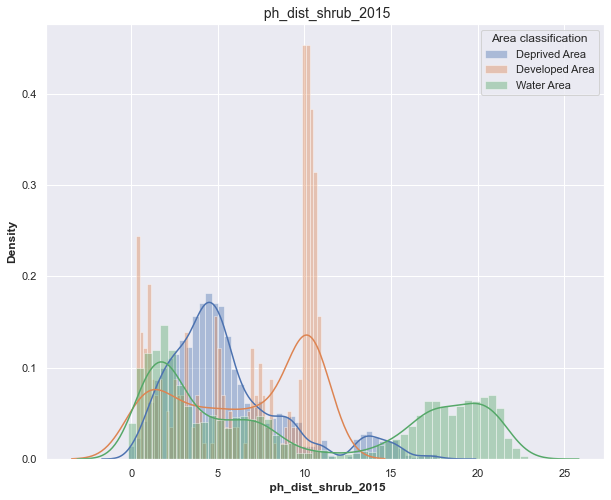

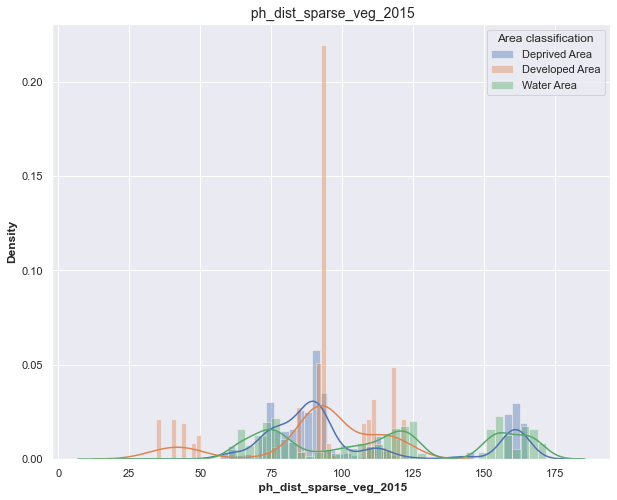

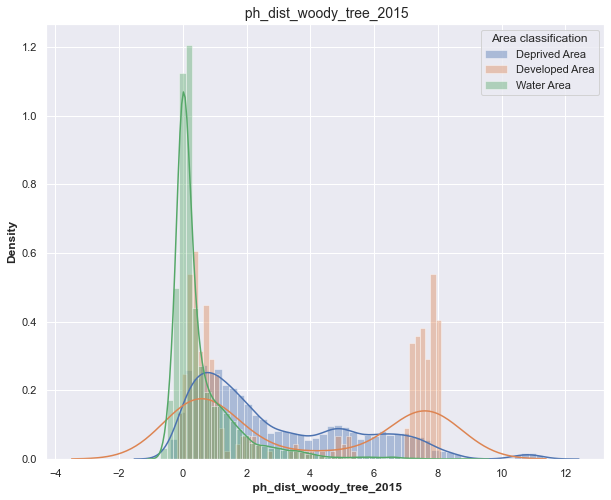

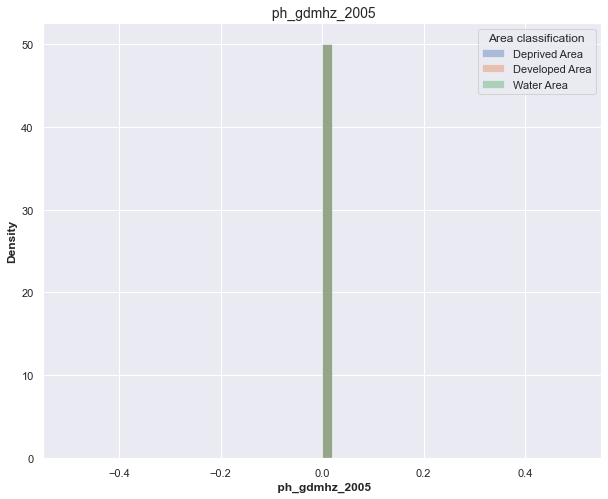

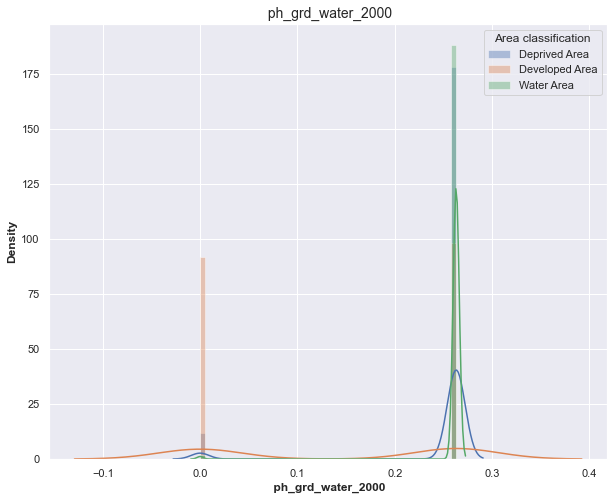

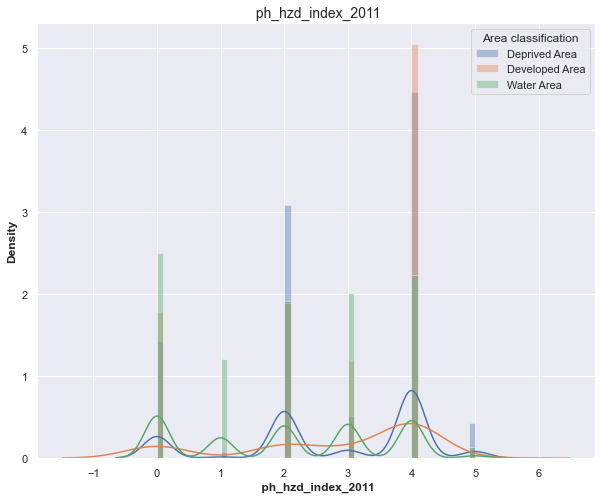

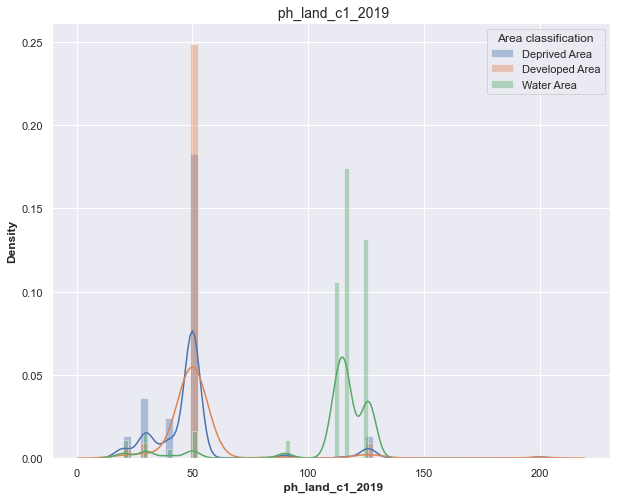

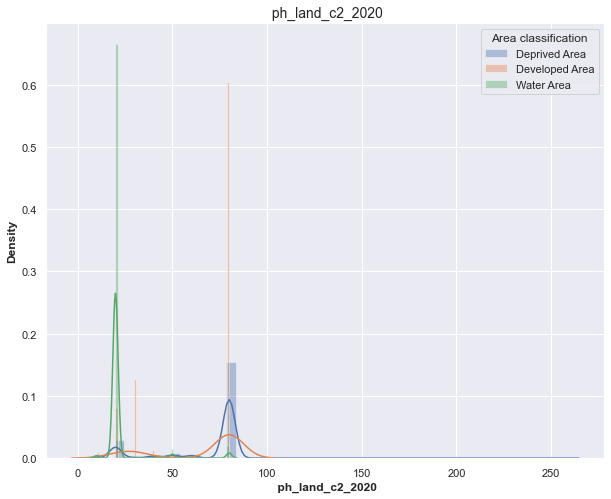

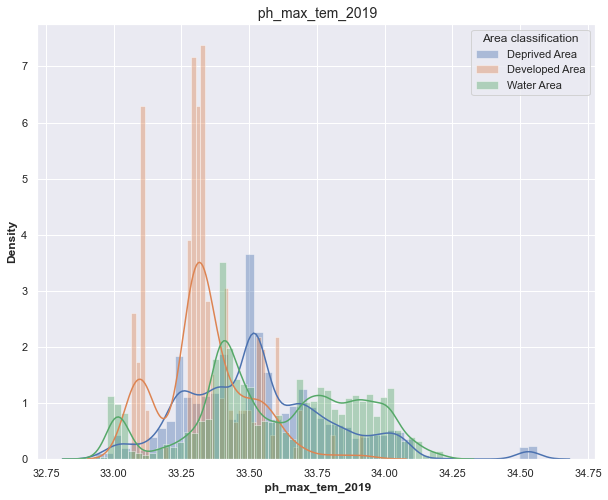

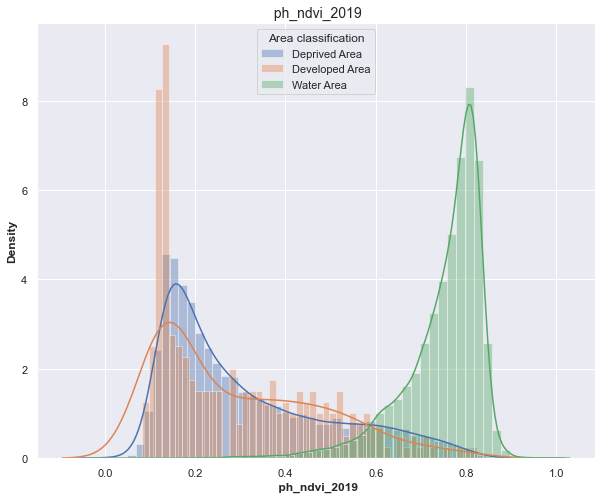

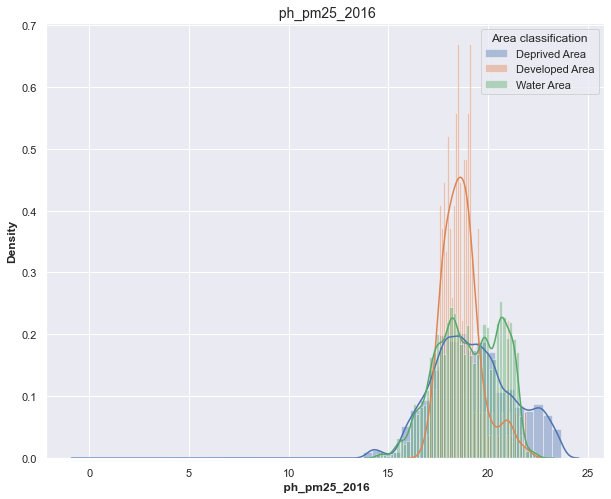

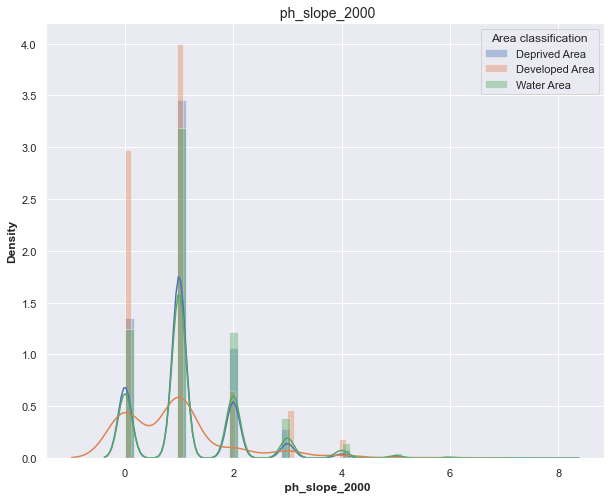

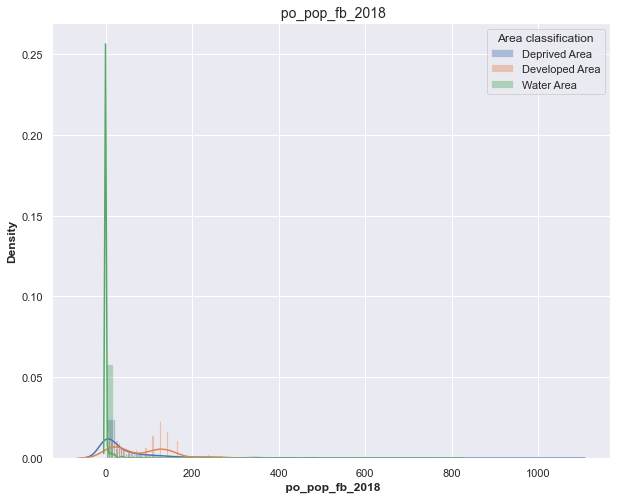

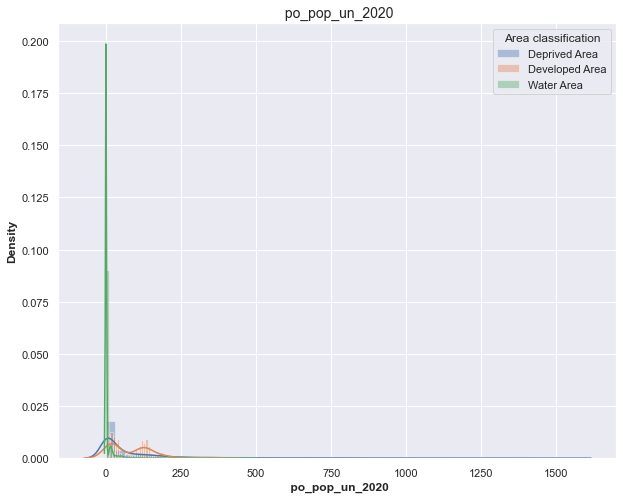

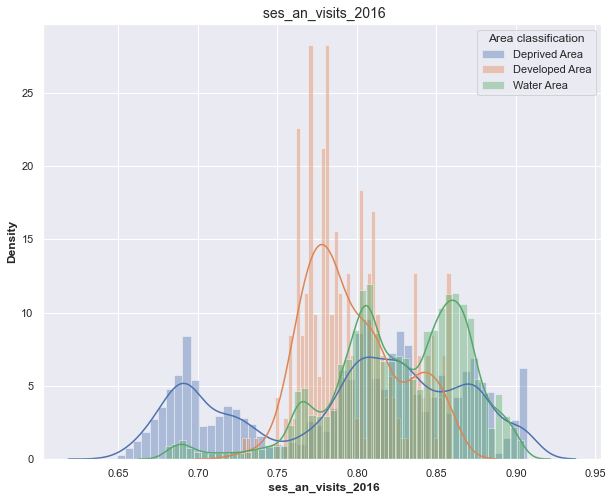

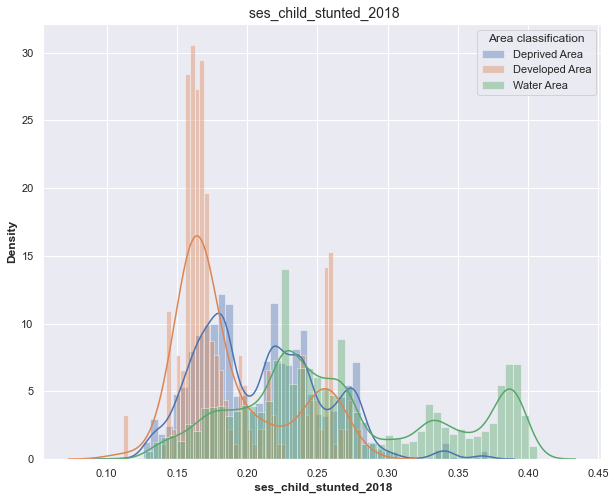

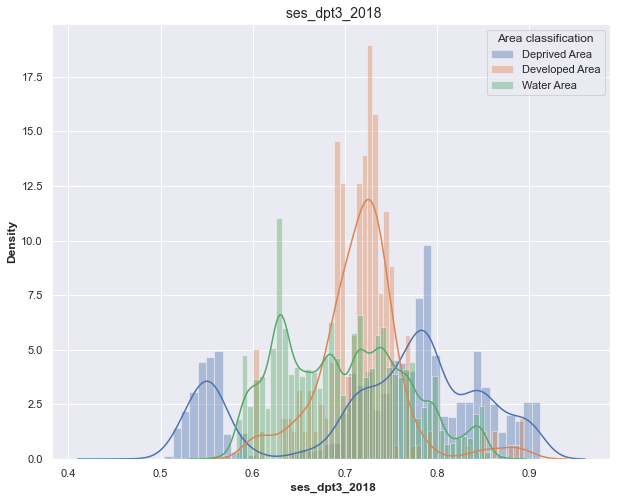

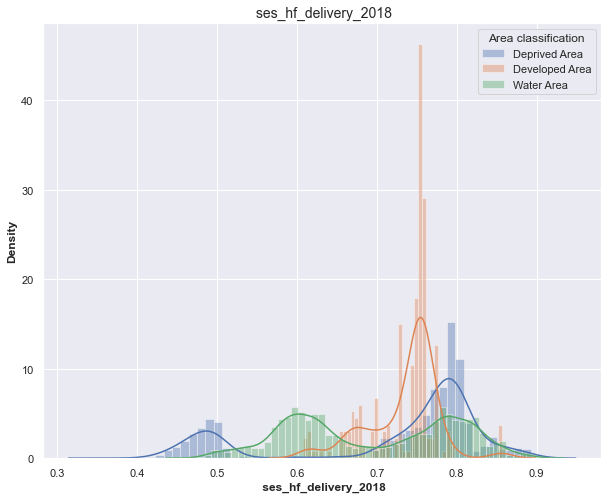

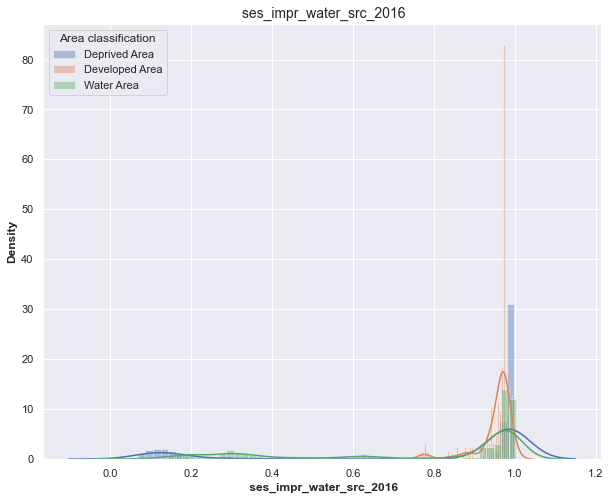

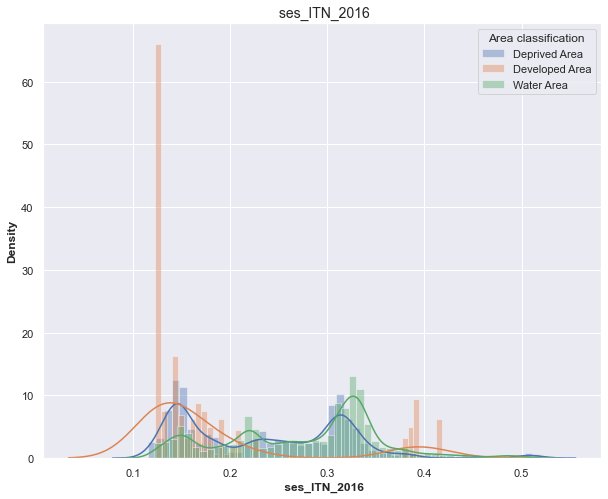

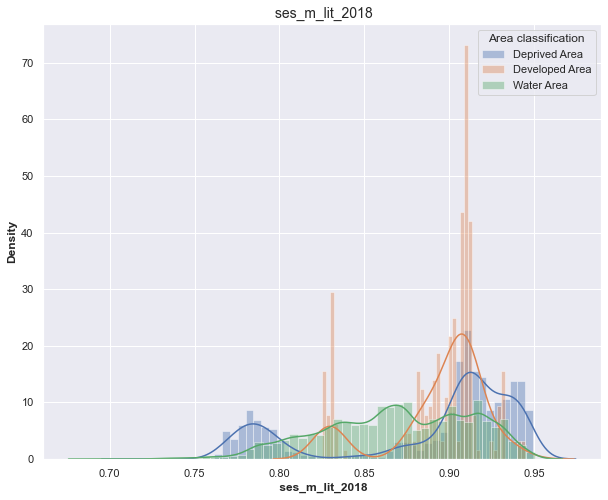

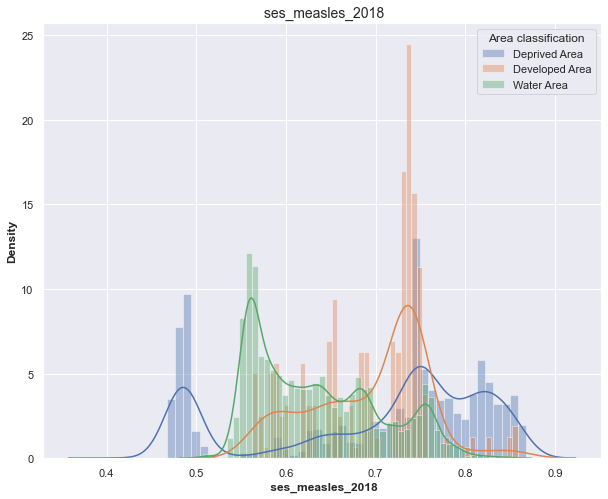

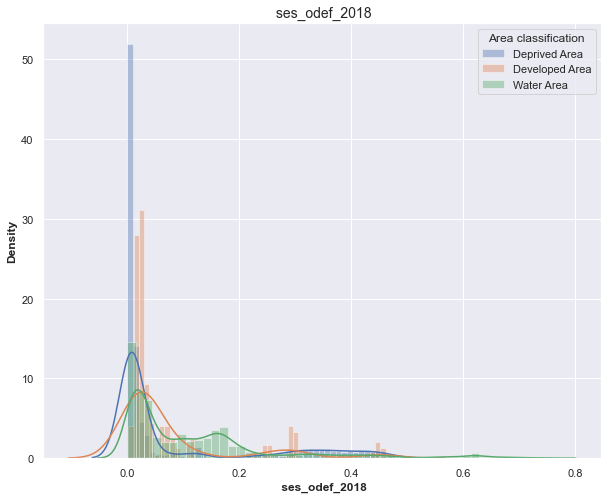

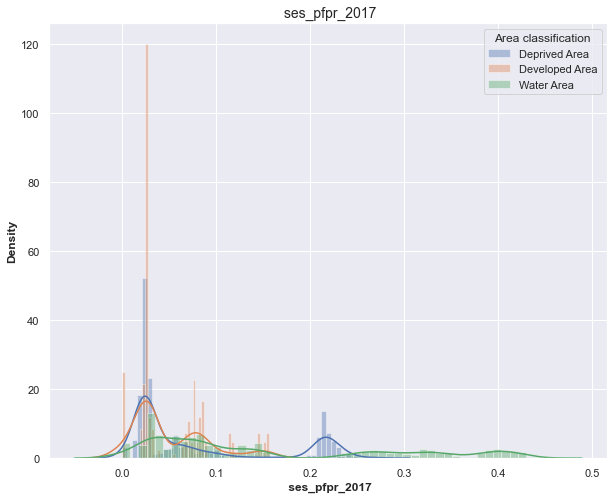

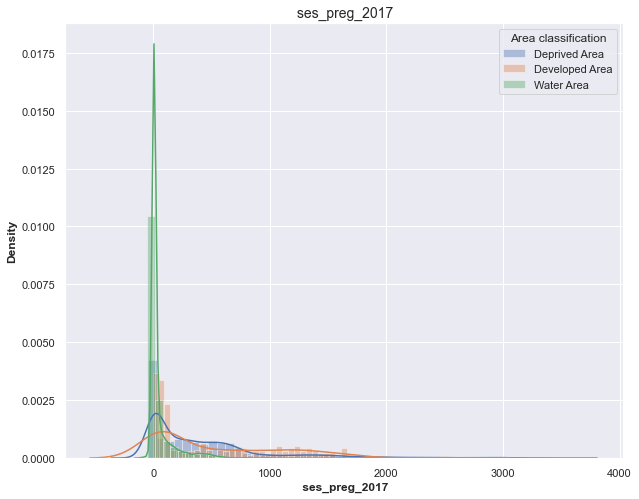

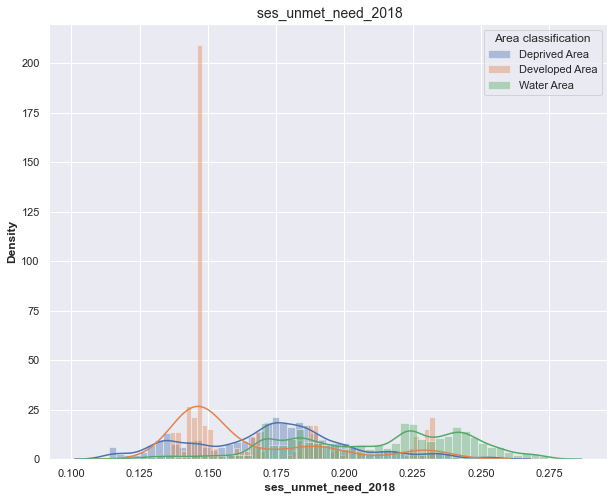

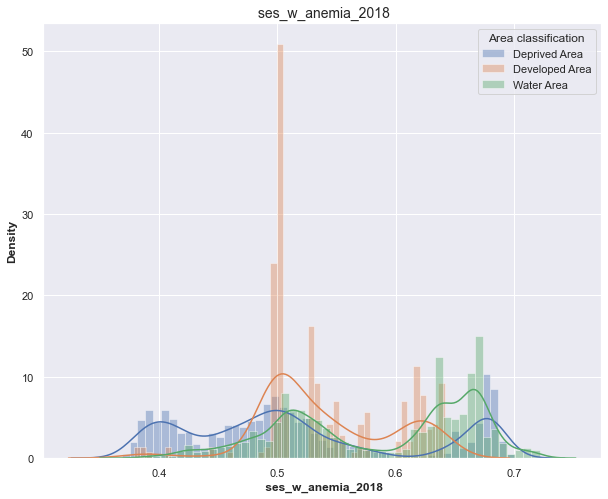

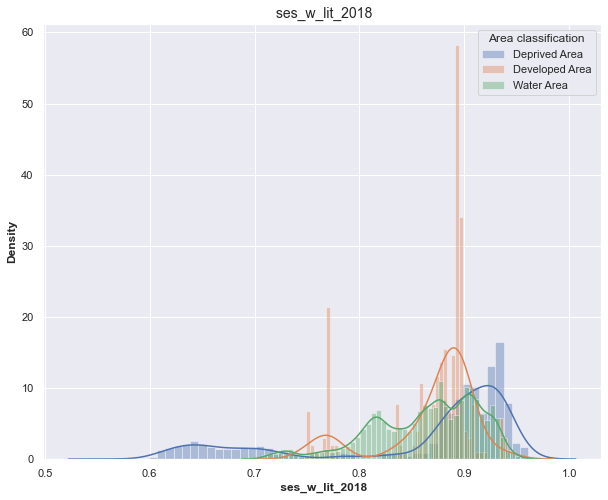

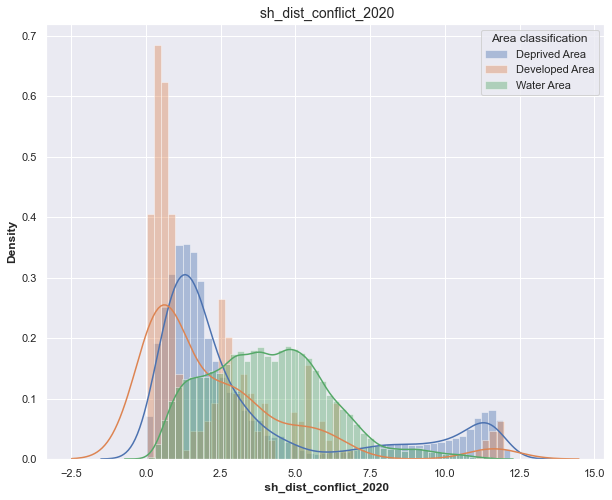

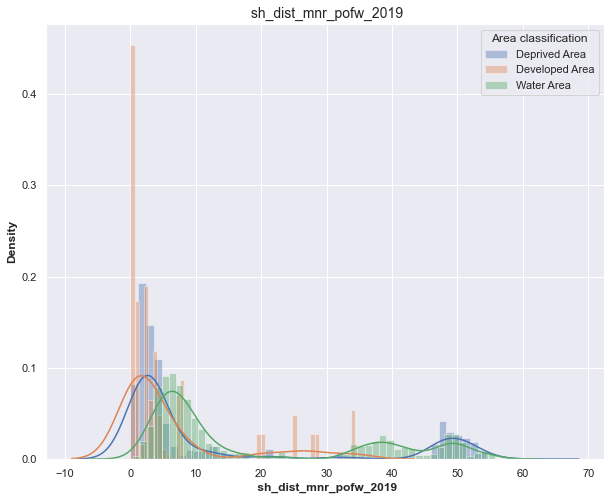

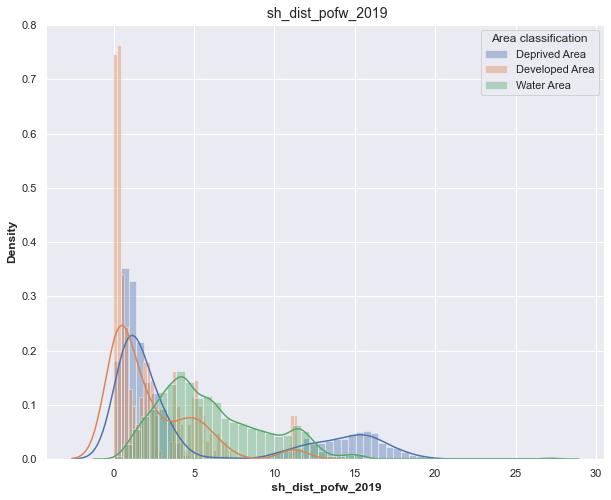

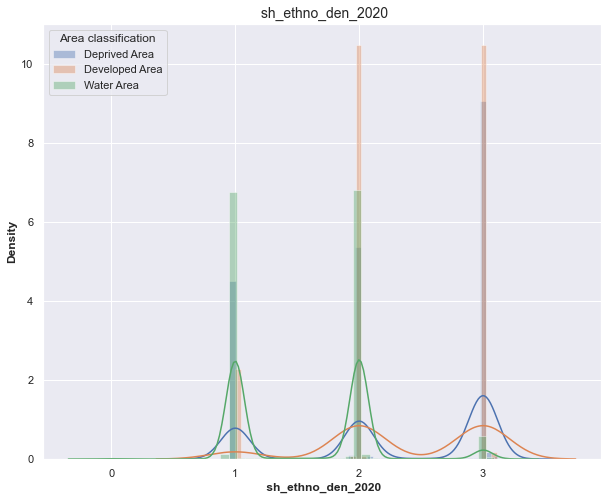

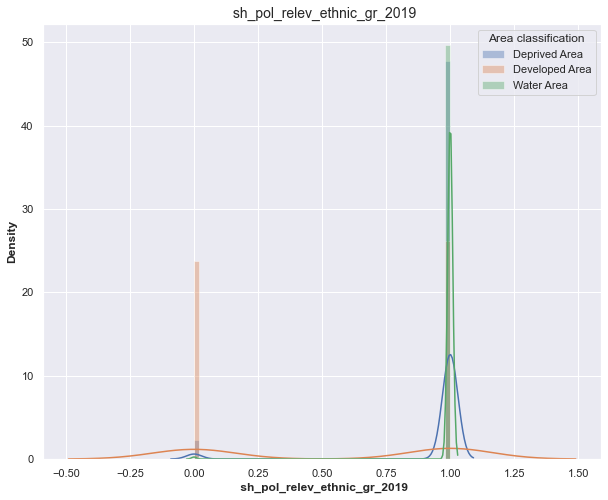

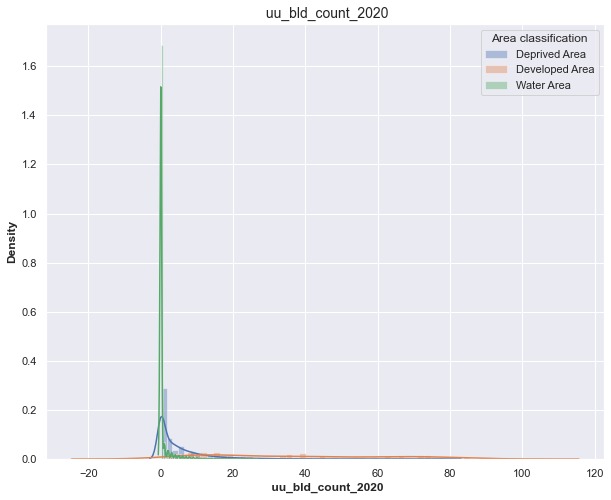

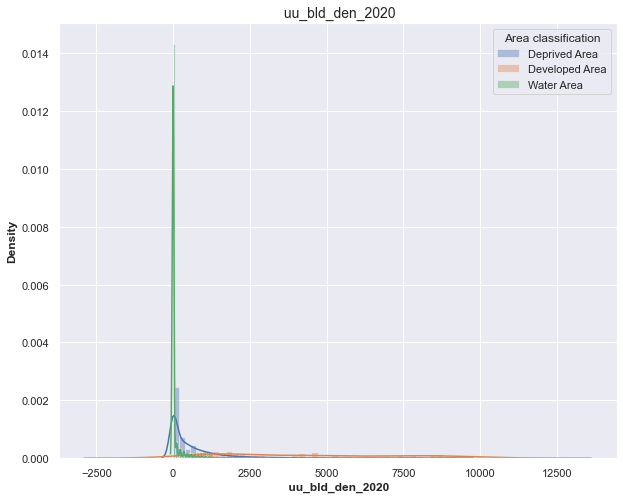

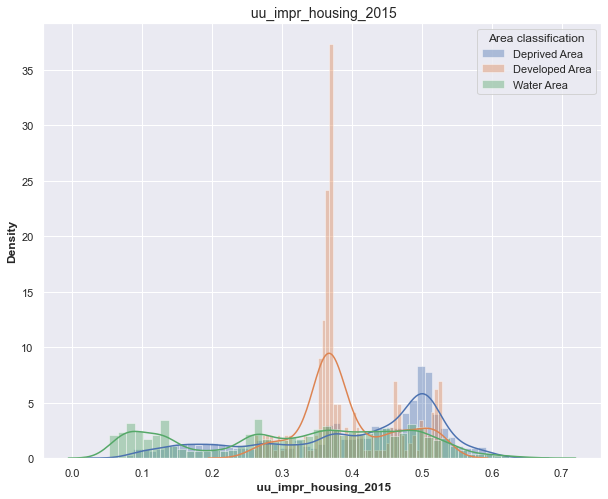

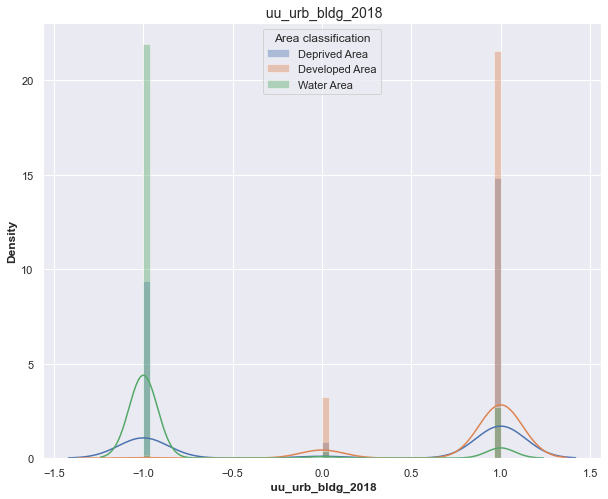

In [63]:
#created distribution plots for the variables
for i in df.columns:
    Distribution_plot(df, "{}".format(i), "Label", "{}".format(i), "{}".format(i))

In [75]:
#heat map on covariates
plt.figure(figsize=(150, 150))
plt.title('Correlation Heat Map of Covariate Data', fontsize= 250)
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, cmap='YlOrRd', square=True)
plt.tight_layout()
plt.show()

In [76]:
df.corr()



Label   fs_dist_fs_2020   fs_dist_hf_2019  \
Label                         1.000000         -0.075671         -0.055865   
 fs_dist_fs_2020             -0.075671          1.000000          0.643678   
 fs_dist_hf_2019             -0.055865          0.643678          1.000000   
 fs_dist_hf1_2020            -0.073782          0.828166          0.632567   
 fs_dist_market_2020         -0.071938          0.899221          0.594790   
 fs_dist_mosques_2017        -0.047402          0.852667          0.529899   
 fs_dist_school_2020         -0.057255          0.943210          0.532314   
 fs_dist_school1_2018        -0.086913          0.791138          0.513758   
 fs_dist_well_2018           -0.089376          0.685227          0.563769   
 fs_electric_dist_2020        0.011334         -0.481129         -0.494063   
 in_dist_rd_2016             -0.001980          0.668466          0.623396   
 in_dist_rd_intersect_2016   -0.041349          0.946289          0.516626   
 in_dist_waterway_2016       -0.042709          0.827186          0.641327   
 in_night_light_2016         -0.055638         -0.483604         -0.411847   
 ph_base_water_2010           0.003724         -0.325704         -0.095720   
 ph_bio_dvst_2015            -0.021106          0.282489          0.229169   
 ph_climate_risk_2020        -0.037764          0.277583          0.018664   
 ph_dist_aq_veg_2015          0.004702         -0.144326          0.116476   
 ph_dist_art_surface_2015     0.031871          0.730853          0.655229   
 ph_dist_bare_2015           -0.033295          0.760583          0.352280   
 ph_dist_cultivated_2015      0.091912         -0.668420         -0.655707   
 ph_dist_herb_2015           -0.079205          0.603998          0.546146   
 ph_dist_inland_water_2018   -0.060308         -0.128756          0.290366   
 ph_dist_open_coast_2020     -0.036380         -0.210755         -0.008115   
 ph_dist_riv_network_2007    -0.071093          0.320849          0.114411   
 ph_dist_shrub_2015           0.038087         -0.061610          0.178067   
 ph_dist_sparse_veg_2015     -0.048401          0.786891          0.389371   
 ph_dist_woody_tree_2015      0.039348         -0.459076         -0.463077   
 ph_gdmhz_2005                     NaN               NaN               NaN   
 ph_grd_water_2000           -0.216976          0.193015          0.189316   
 ph_hzd_index_2011            0.001195         -0.428859         -0.355496   
 ph_land_c1_2019              0.012331         -0.119042         -0.042505   
 ph_land_c2_2020             -0.015758         -0.035761         -0.139973   
 ph_max_tem_2019             -0.096197          0.123358          0.072746   
 ph_ndvi_2019                -0.012726         -0.067439          0.150874   
 ph_pm25_2016                -0.036971          0.466365          0.148604   
 ph_slope_2000               -0.024690          0.091359          0.029636   
 po_pop_fb_2018               0.015738         -0.393408         -0.390110   
 po_pop_un_2020               0.000943         -0.379177         -0.386801   
 ses_an_visits_2016           0.006793         -0.549778         -0.154141   
 ses_child_stunted_2018      -0.063729          0.594386          0.329061   
 ses_dpt3_2018               -0.024425         -0.882925         -0.602919   
 ses_hf_delivery_2018         0.017304         -0.842465         -0.437683   
 ses_impr_water_src_2016      0.057149         -0.899551         -0.527291   
 ses_ITN_2016                -0.078970          0.772172          0.664367   
 ses_m_lit_2018               0.016615         -0.940015         -0.597579   
 ses_measles_2018            -0.004906         -0.929238         -0.658696   
 ses_odef_2018               -0.009416          0.903807          0.553244   
 ses_pfpr_2017               -0.046922          0.913829          0.575267   
 ses_preg_2017                0.020246         -0.494443         -0.480765   
 ses_unmet_need_2018         -0.040705          0.23825

# Splitting and standardizing data for analysis

In [77]:
# seperate independent and dependent variables
# removed ph_gdmhz_2005 as it had nan values 
X = df.drop(['Label',' ph_gdmhz_2005'], axis=1)
y = df['Label']
# train, val, test split 60/20/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

#create X_train_PCA dataframe for feature selection in PCA
X_train_PCA = X_train.copy()

In [78]:
# Standardize Features for training and test set
# The StandardScaler
ss = StandardScaler()
# Standardize the training data
X_train = ss.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train, columns= X.columns)
# Standardize Validation data
X_val = ss.fit_transform(X_val)
X_val_scaled = pd.DataFrame(X_val, columns= X.columns)
#Standardize Testing data
X_test = ss.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test, columns= X.columns)

In [79]:
# Check shape of split data 
print('There are', X_train_scaled.shape[0], 'rows in the train data')
print('There are', X_val_scaled.shape[0], 'rows in the validation data')
print('There are', X_test_scaled.shape[0], 'rows in the test data')

There are 9282 rows in the train data
There are 3094 rows in the validation data
There are 3094 rows in the test data


In [80]:
# Make directory to save results 
directory = os.path.dirname('result/cv_results/GridSearchCV/')
if not os.path.exists(directory):
    os.makedirs(directory)

# Random Forest Model with Test Data

# For Classes 0 and 1

# Splitting and standardizing data for analysis

In [81]:
# select 0 and 1 classes
df =df[df['Label'].isin([0,1])]
X = df.drop('Label', axis=1)
y = df['Label']
# train, val, test split 60/20/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

In [82]:
# Standardize Features for training and test set
# The StandardScaler
ss = StandardScaler()
# Standardize the training data
X_train = ss.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train, columns= X.columns)
# Standardize Validation data
X_val = ss.fit_transform(X_val)
X_val_scaled = pd.DataFrame(X_val, columns= X.columns)
#Standardize Testing data
X_test = ss.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test, columns= X.columns)

In [83]:
# Check shape of split data 
print('There are', X_train_scaled.shape[0], 'rows in the train data')
print('There are', X_val_scaled.shape[0], 'rows in the validation data')
print('There are', X_test_scaled.shape[0], 'rows in the test data')

There are 9282 rows in the train data
There are 3094 rows in the validation data
There are 3094 rows in the test data


# Random Forest Model with Test Data

In [84]:
models = {'rfc': RandomForestClassifier( random_state=42)}
pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])
param_grids = {}
# Random Forest Hyper Parameters
# The grids for min_samples_split
min_samples_split_grids = [2,10, 20, 50, 100]

# The grids for min_samples_leaf
min_samples_leaf_grids = [1,10, 20, 50, 100]

# Update param_grids
param_grids['rfc'] = [{'model__min_samples_split': min_samples_split_grids,
                       'model__min_samples_leaf': min_samples_leaf_grids}]

In [85]:
# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_params_estimator_gs = []
# GridSearchCV
gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='f1_macro',
                      n_jobs=1,
                      cv=StratifiedKFold(),
                      return_train_score=True)
        
# Fit the pipeline
gs = gs.fit(X_train_scaled, y_train)
    
# Update best_score_params_estimator_gs
best_score_params_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
# Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
# Get the important columns in cv_results
important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
# Move the important columns ahead
cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

# Write cv_results file
cv_results.to_csv(path_or_buf='result/cv_results/GridSearchCV/' + acronym + '.csv', index=False)

# Sort best_score_params_estimator_gs in descending order of the best_score_
best_score_params_estimator_gs = sorted(best_score_params_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_params_estimator_gs
pd.DataFrame(best_score_params_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

best_score                                         best_param  \
0    0.955697  {'model__min_samples_leaf': 1, 'model__min_sam...   

                                      best_estimator  
0  ((DecisionTreeClassifier(max_features='auto', ...

In [86]:
best_score_gs, best_params_gs, best_estimator_gs = best_score_params_estimator_gs[0]


In [87]:
# Predict using test data
y_test_pred = best_estimator_gs.predict(X_test_scaled)

# Get the precision, recall, fscore, support
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_test_pred)


# Get the dataframe of precision, recall, fscore and auc
pd.DataFrame([[precision, recall, fscore]], columns=['Precision', 'Recall', 'F1-score'])

Precision                     Recall  \
0  [0.9963780046098123, 1.0]  [1.0, 0.8382352941176471]   

                                   F1-score  
0  [0.9981857166419265, 0.9119999999999999]

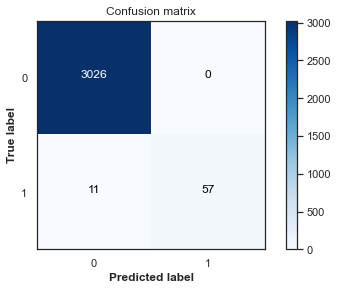

In [88]:
# Plotting confusion matrix obtained from the testing data predictions
sns.set(style="white")
cnf_matrix = confusion_matrix(y_test,y_test_pred)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
class_names = ["0","1"]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

In [89]:
print(classification_report(y_test,y_test_pred))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3026
           1       1.00      0.84      0.91        68

    accuracy                           1.00      3094
   macro avg       1.00      0.92      0.96      3094
weighted avg       1.00      1.00      1.00      3094



In [90]:
target="label"
# Get the best_score, best_param and best_estimator of random forest obtained by GridSearchCV
best_score_rfc, best_param_rfc, best_estimator_rfc = best_score_params_estimator_gs[0]

# Get the dataframe of feature and importance
df_fi_rfc_0_1 = pd.DataFrame(np.hstack((np.setdiff1d(X.columns, [target]).reshape(-1, 1), best_estimator_rfc.named_steps['model'].feature_importances_.reshape(-1, 1))),
                         columns=['Features', 'Importance'])

# Sort df_fi_rfc in descending order of the importance
df_fi_rfc_0_1 = df_fi_rfc_0_1.sort_values(ascending=False, by='Importance').reset_index(drop=True)

# Print the first 5 rows of df_fi_rfc
df_fi_rfc_0_1.head()

#save results as csv
df_fi_rfc_0_1.to_csv(path_or_buf='feature_selection/Covariate_features/' + 'Covariate_best_random_forest_features_0_1.csv',index=False)

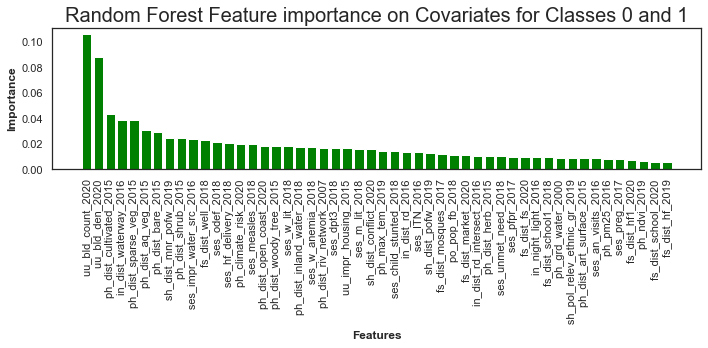

In [91]:
#Create a figure
fig = plt.figure(figsize=(10, 5))

# Implement me
# The bar plot of the top 5 feature importance
plt.bar(df_fi_rfc_0_1['Features'][:50], df_fi_rfc_0_1['Importance'][:50], color='green')

# Set x-axis
plt.title('Random Forest Feature importance on Covariates for Classes 0 and 1', fontsize=20)
plt.xlabel('Features')
plt.xticks(rotation=90)

# Set y-axis
plt.ylabel('Importance')

# Save and show the figure
plt.tight_layout()
plt.show()

# Random Forest Model with Validation Data

In [92]:
# Predict using test data
y_val_pred = best_estimator_gs.predict(X_val_scaled)

# Get the precision, recall, fscore, support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred)


# Get the dataframe of precision, recall, fscore and auc
pd.DataFrame([[precision, recall, fscore]], columns=['Precision', 'Recall', 'F1-score'])

Precision                                    Recall  \
0  [0.9980302035456337, 0.9375]  [0.9990141307919816, 0.8823529411764706]   

                                   F1-score  
0  [0.9985219247823947, 0.9090909090909091]

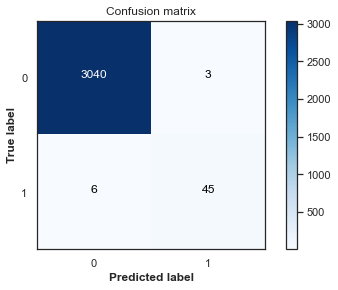

In [93]:
# Plotting confusion matrix obtained from the testing data predictions
sns.set(style="white")
cnf_matrix = confusion_matrix(y_val,y_val_pred)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
class_names = ["0","1"]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

In [94]:
print(classification_report(y_val,y_val_pred))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3043
           1       0.94      0.88      0.91        51

    accuracy                           1.00      3094
   macro avg       0.97      0.94      0.95      3094
weighted avg       1.00      1.00      1.00      3094



# Logistic Model Building with no Balanced Classes on Testing Data

In [95]:
# manually set weights
models = {'lr': LogisticRegression(solver= "lbfgs", random_state=42)}


pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])
param_grids = {}

# Logistic Regression hyperparamters

# The parameter grid of tol
tol_grid = [10 ** -5, 10 ** -4, 10 ** -3, 10 ** -2, 10 ** -1]

# The parameter grid of C
C_grid = [0.001, 0.0001, 0.1, 1, 10]

param_grids['lr'] = [{'model__tol': tol_grid,
                      'model__C': C_grid}]


In [96]:
# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_params_estimator_gs = []
# GridSearchCV
gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='f1_macro',
                      n_jobs=-1,
                      cv=StratifiedKFold(),
                      return_train_score=True)
        
# Fit the pipeline
gs = gs.fit(X_train, y_train)
    
# Update best_score_params_estimator_gs
best_score_params_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
# Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
# Get the important columns in cv_results
important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
# Move the important columns ahead
cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

# Write cv_results file
cv_results.to_csv(path_or_buf='result/cv_results/GridSearchCV/' + acronym +  'stratifiedCV.csv', index=False)

# Sort best_score_params_estimator_gs in descending order of the best_score_
best_score_params_estimator_gs = sorted(best_score_params_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_params_estimator_gs
pd.DataFrame(best_score_params_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

best_score                             best_param  \
0    0.929718  {'model__C': 10, 'model__tol': 1e-05}   

                                      best_estimator  
0  (LogisticRegression(C=10, random_state=42, tol...

In [97]:
best_score_gs, best_params_gs, best_estimator_gs = best_score_params_estimator_gs[0]
# Predict using test data
y_test_pred = best_estimator_gs.predict(X_test_scaled)

# Get the precision, recall, fscore, support
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_test_pred)


# Get the dataframe of precision, recall, fscore and auc
pd.DataFrame([[precision, recall, fscore]], columns=['Precision', 'Recall', 'F1-score'])

Precision  \
0  [0.9967029343883943, 0.9508196721311475]   

                                     Recall  \
0  [0.9990085922009253, 0.8529411764705882]   

                                   F1-score  
0  [0.9978544314243274, 0.8992248062015503]

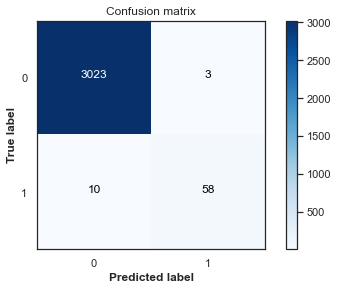

In [98]:
# Plotting confusion matrix obtained from the testing data predictions
sns.set(style="white")
cnf_matrix = confusion_matrix(y_test,y_test_pred)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
class_names = ["0","1"]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

In [99]:
 print(classification_report(y_test,y_test_pred))

    

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3026
           1       0.95      0.85      0.90        68

    accuracy                           1.00      3094
   macro avg       0.97      0.93      0.95      3094
weighted avg       1.00      1.00      1.00      3094



# Logistic Model Building with no Balanced Classes on Validation Data

In [100]:
# manually set weights
models = {'lr': LogisticRegression(solver= "lbfgs", random_state=42)}


pipes = {}

for acronym, model in models.items():
    pipes[acronym] = Pipeline([('model', model)])
param_grids = {}

# Logistic Regression hyperparamters

# The parameter grid of tol
tol_grid = [10 ** -5, 10 ** -4, 10 ** -3, 10 ** -2, 10 ** -1]

# The parameter grid of C
C_grid = [0.001, 0.0001, 0.1, 1, 10]

param_grids['lr'] = [{'model__tol': tol_grid,
                      'model__C': C_grid}]


In [101]:
# The list of [best_score_, best_params_, best_estimator_] obtained by GridSearchCV
best_score_params_estimator_gs = []
# GridSearchCV
gs = GridSearchCV(estimator=pipes[acronym],
                      param_grid=param_grids[acronym],
                      scoring='f1_macro',
                      n_jobs=-1,
                      cv=StratifiedKFold(),
                      return_train_score=True)
        
# Fit the pipeline
gs = gs.fit(X_train, y_train)
    
# Update best_score_params_estimator_gs
best_score_params_estimator_gs.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
    
# Sort cv_results in ascending order of 'rank_test_score' and 'std_test_score'
cv_results = pd.DataFrame.from_dict(gs.cv_results_).sort_values(by=['rank_test_score', 'std_test_score'])
    
# Get the important columns in cv_results
important_columns = ['rank_test_score',
                         'mean_test_score', 
                         'std_test_score', 
                         'mean_train_score', 
                         'std_train_score',
                         'mean_fit_time', 
                         'std_fit_time',                        
                         'mean_score_time', 
                         'std_score_time']
    
# Move the important columns ahead
cv_results = cv_results[important_columns + sorted(list(set(cv_results.columns) - set(important_columns)))]

# Write cv_results file
cv_results.to_csv(path_or_buf='result/cv_results/GridSearchCV/' + acronym +  'stratifiedCV.csv', index=False)

# Sort best_score_params_estimator_gs in descending order of the best_score_
best_score_params_estimator_gs = sorted(best_score_params_estimator_gs, key=lambda x : x[0], reverse=True)

# Print best_score_params_estimator_gs
pd.DataFrame(best_score_params_estimator_gs, columns=['best_score', 'best_param', 'best_estimator'])

best_score                             best_param  \
0    0.929718  {'model__C': 10, 'model__tol': 1e-05}   

                                      best_estimator  
0  (LogisticRegression(C=10, random_state=42, tol...

In [102]:
best_score_gs, best_params_gs, best_estimator_gs = best_score_params_estimator_gs[0]
# Predict using test data
y_val_pred = best_estimator_gs.predict(X_val_scaled)

# Get the precision, recall, fscore, support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred)


# Get the dataframe of precision, recall, fscore and auc
pd.DataFrame([[precision, recall, fscore]], columns=['Precision', 'Recall', 'F1-score'])

Precision  \
0  [0.9973736047275115, 0.8958333333333334]   

                                     Recall  \
0  [0.9983568846533026, 0.8431372549019608]   

                                   F1-score  
0  [0.9978650024634587, 0.8686868686868686]

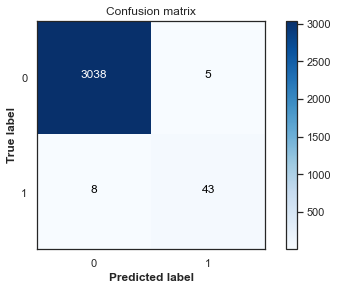

In [103]:
# Plotting confusion matrix obtained from the testing data predictions
sns.set(style="white")
cnf_matrix = confusion_matrix(y_val,y_val_pred)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
class_names = ["0","1"]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

In [104]:
 print(classification_report(y_val,y_val_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3043
           1       0.90      0.84      0.87        51

    accuracy                           1.00      3094
   macro avg       0.95      0.92      0.93      3094
weighted avg       1.00      1.00      1.00      3094



In [110]:
# Evaluate odds of each variable and sort by odds value
odds = np.exp(best_estimator_gs["model"].coef_[0])
best_log =pd.DataFrame(odds, X_train_scaled.columns, columns=['odds']).sort_values(by='odds', ascending=False)
best_log.reset_index(inplace=True)
best_log.rename(columns={'index':'Covariate_features','odds':'values'},inplace=True)
best_log.head()

Covariate_features       values
0               ses_odef_2018  1050.671280
1     ses_impr_water_src_2016   484.132543
2   in_dist_rd_intersect_2016   244.741557
3           ses_w_anemia_2018    37.738917
4         fs_dist_school_2020    15.244518

In [107]:
#save best logistic features in csv file
best_log.to_csv(path_or_buf='feature_selection/Covariate_features/' + 'Covariate_best_logistic_features_0_1.csv',index=False)



# PCA Feature Selection- class 0 and 1

In [58]:
from sklearn.decomposition import PCA
pca = PCA() # estimate only 2 PCs
X_new = pca.fit_transform(X_train_scaled)

In [59]:
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
n_to_reach_95 = abs(X_new.shape[1] - n_over_95 + 1)
print("Number features: {}\tTotal Variance Explained: {}".format(n_to_reach_95, total_explained_variance[n_to_reach_95-1]))

Number features: 23	Total Variance Explained: 0.9533728810174212


In [60]:
#create pipe line for selecting features
pipe = Pipeline([('scaler', StandardScaler()),
 ('pca', PCA(n_components=60,random_state=42)),
 ('clf', RandomForestClassifier())])
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=60, random_state=42)),
                ('clf', RandomForestClassifier())])

In [61]:
#show cumulative variance explained for first 23 components
pca.explained_variance_ratio_.cumsum()[0:23]

array([0.46, 0.57, 0.64, 0.68, 0.72, 0.74, 0.77, 0.79, 0.81, 0.83, 0.84,
       0.86, 0.87, 0.88, 0.9 , 0.91, 0.92, 0.92, 0.93, 0.94, 0.94, 0.95,
       0.95])

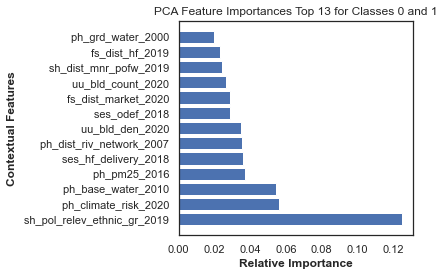

In [64]:
model = pipe.steps[1][1]
n_pcs= model.components_.shape[0]
initial_feature_names = X_train_scaled.columns
# loop through the absolute value of 60 pca components in model and select the largest value
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)] 
# create list of most important features
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
# run values through random forest to extract feature importance 
zipped_feats = zip(most_important_names, pipe.steps[2][1].feature_importances_)
#sort feature importance values
zipped_feats = sorted(zipped_feats, key=lambda x: x[1], reverse=True)
features, importances = zip(*zipped_feats)
top_features = features[:13]
top_importances = importances[:13]
plt.figure()
plt.title('PCA Feature Importances Top 13 for Classes 0 and 1')
plt.barh(range(len(top_importances)), top_importances, color='b', align='center')
plt.yticks(range(len(top_importances)), top_features)
plt.xlabel('Relative Importance')
plt.ylabel('Contextual Features')
plt.tight_layout()
plt.show()

In [65]:
#Convert top features into a dataframe
top_pca_names_0_1 = pd.DataFrame(features)
top_pca_values_0_1 = pd.DataFrame(importances)
top_pca_0_1 = top_pca_names_0_1.merge(top_pca_values_0_1, left_index=True,right_index=True)
top_pca_0_1= top_pca_0_1.rename(columns={'0_x':'names','0_y':'values'})
top_pca_0_1.to_csv(path_or_buf='feature_selection/Covariate_features/' + 'Covariate_best_pca_features_0_1.csv',index=False)
top_pca_0_1.head()

names    values
0   sh_pol_relev_ethnic_gr_2019  0.124968
1          ph_climate_risk_2020  0.056185
2            ph_base_water_2010  0.054468
3                  ph_pm25_2016  0.037145
4          ses_hf_delivery_2018  0.036120

In [66]:
# 13 values are repeated
top_pca_0_1.names.duplicated().value_counts()

False    47
True     13
Name: names, dtype: int64

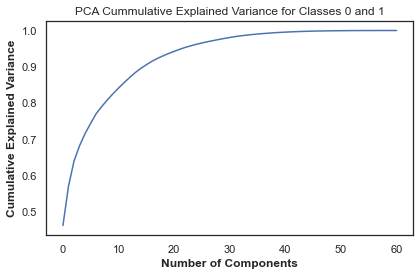

In [67]:
#plot cummulative explained variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA Cummulative Explained Variance for Classes 0 and 1')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.tight_layout()
plt.show()

In [50]:
# use list comprehension to find most useful variable within each principle component
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
ef = pd.DataFrame(dic.items(), columns = ['Component','Covariate_features'])

NameError: name 'n_pcs' is not defined

# Comparing Feature Selections of Different Models

In [111]:


# Random Forest feature importance two classes
df_fi_rfc_0_1 = df_fi_rfc_0_1.rename(columns = {'Features':'Covariate_features','Importance':'values'})
df_fi_rfc_0_1['top_Random_Forest_0_1']= range(1,len(df_fi_rfc_0_1)+1)
df_fi_rfc_0_1.drop(['values'],axis=1, inplace=True)

# logisitc featue importance for two classes
best_log['top_logistic_0_1'] = range(1,len(best_log)+1)
best_log.drop(['values'],axis=1, inplace=True)
best_log.head()

Covariate_features  top_logistic_0_1
0               ses_odef_2018                 1
1     ses_impr_water_src_2016                 2
2   in_dist_rd_intersect_2016                 3
3           ses_w_anemia_2018                 4
4         fs_dist_school_2020                 5

In [70]:
# Top PCA Features three classes
top_pca['top_PCA']= range(1,len(top_pca)+1)
top_pca = top_pca.rename(columns = {'names':'Covariate_features'})


# Top PCA Features two classes
top_pca_0_1['top_PCA_0_1']= range(1,len(top_pca_0_1)+1)
top_pca_0_1 = top_pca_0_1.rename(columns = {'names':'Covariate_features'})


top_pca.head(10)

Covariate_features    values  top_PCA
0              ses_measles_2018  0.173388        1
1            ses_an_visits_2016  0.169883        2
2               ph_max_tem_2019  0.091867        3
3   sh_pol_relev_ethnic_gr_2019  0.073835        4
4         in_dist_waterway_2016  0.055595        5
5                po_pop_un_2020  0.027823        6
6               uu_bld_den_2020  0.017852        7
7              ph_bio_dvst_2015  0.017496        8
8               uu_bld_den_2020  0.016755        9
9      ph_dist_riv_network_2007  0.015839       10

In [ ]:
top_pca['top_PCA']= range(1,len(top_pca)+1)
top_pca = top_pca.rename(columns = {'names':'Covariate_features'})

top_pca.iloc[8]
top_pca.head(

In [116]:
best_log.head()

Covariate_features  top_logistic_0_1
0               ses_odef_2018                 1
1     ses_impr_water_src_2016                 2
2   in_dist_rd_intersect_2016                 3
3           ses_w_anemia_2018                 4
4         fs_dist_school_2020                 5

In [118]:
#merge best featurees 
best = best_log.merge(df_fi_rfc_0_1[['Covariate_features','top_Random_Forest_0_1']],how='inner', on = 'Covariate_features')

#create rank column
best['overall_rank'] = best['top_logistic_0_1'] + best['top_Random_Forest_0_1'] 

best = best.sort_values(by= ['overall_rank'], ascending =True).reset_index(drop=True)
best['rank']= range(1,len(best)+1)
best.head(20)

Covariate_features  top_logistic_0_1  top_Random_Forest_0_1  \
0      ses_impr_water_src_2016                 2                     10   
1                ses_odef_2018                 1                     12   
2      ph_dist_cultivated_2015                11                      3   
3          ph_dist_aq_veg_2015                13                      6   
4             ses_measles_2018                 7                     15   
5            ses_w_anemia_2018                 4                     20   
6              uu_bld_den_2020                24                      2   
7            uu_bld_count_2020                25                      1   
8         ph_climate_risk_2020                21                     14   
9    in_dist_rd_intersect_2016                 3                     34   
10             ph_max_tem_2019                14                     26   
11               ses_dpt3_2018                18                     22   
12         fs_dist_market_2020                 9                     33   
13           ph_dist_herb_2015                10                     35   
14       in_dist_waterway_2016                44                      4   
15               ses_pfpr_2017                12                     37   
16        uu_impr_housing_2015                26                     23   
17      ses_child_stunted_2018                22                     27   
18          ses_an_visits_2016                 6                     44   
19    ph_dist_art_surface_2015                 8                     43   

    overall_rank  rank  
0             12     1  
1             13     2  
2             14     3  
3             19     4  
4             22     5  
5             24     6  
6             26     7  
7             26     8  
8             35     9  
9             37    10  
10            40    11  
11            40    12  
12            42    13  
13            45    14  
14            48    15  
15            49    16  
16            49    17  
17            49    18  
18            50    19  
19            51    20